# Современные методы анализа данных и машинного обучения, БИ

## НИУ ВШЭ, 2024-25 учебный год

# Семинар 16. Временные ряды

Сегодняшний семинар у нас посвящён обсуждению важнейшего процесса в анализе данных — анализу и прогнозированию временных рядов. Начнём с самого начала и постепенно вместе дойдем до вполне продвинутых и серьезных моделей. Поехали!

## Постановка задачи временных рядов

Временной ряд — это собранный в разные моменты времени статистический материал о значении каких-либо параметров исследуемого процесса.

Скалярным временным рядом

$$\{x_i\}_{i=1}^N$$

называется массив из $N$ чисел, представляющих собой значения некоторой измеренной (наблюдаемой) динамической переменной $x(t)$ с некоторым постоянным шагом $τ$ по времени,

 $$t_i = t_0 + (i − 1)τ : x_i = x(t_i), i = 1, . . . , N.$$

### Примеры временных рядов

В качестве некоторых примеров временных рядов можем выделить следующие массивы данных:

- объёмы продаж в торговых сетях
- объёмы потребления и цены на электроэнергию
- остатки складских запасов
- рыночные цены на акции
- дорожный трафик (загруженность дорог)
- цены на криптовалюту

И многие другие.

#### Вопрос

Какие задачи возникают в каждом из этих случаев? И как их можно все вместе объединить в одном предложении?

#### Вопрос

Приведите свои примеры временных рядов и задач, возникающих в рамках них.

### Чтение данных

Сегодня мы поработаем с вами с данными по продажам товаров в Индии в различных городах и штатах.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

Загрузим датасет и посмотрим на структуру данных.

In [2]:
df = pd.read_csv('MarketArrivals_Ind.csv')

In [3]:
df.shape

(10227, 10)

In [4]:
df.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
0  ABOHAR(PB)  January  2005      2350       404       493       446    PB   
1  ABOHAR(PB)  January  2006       900       487       638       563    PB   
2  ABOHAR(PB)  January  2010       790      1283      1592      1460    PB   
3  ABOHAR(PB)  January  2011       245      3067      3750      3433    PB   
4  ABOHAR(PB)  January  2012      1035       523       686       605    PB   

     city          date  
0  ABOHAR  January-2005  
1  ABOHAR  January-2006  
2  ABOHAR  January-2010  
3  ABOHAR  January-2011  
4  ABOHAR  January-2012

Как можно видеть, в нашем датафрейме всего присутствует 10 столбцов.

По типам данных они распределяются следующим образом:

- **CATEGORICAL**: state, city, market
- **NUMERICAL**: quantity, priceMin, priceMax, priceModal
- **TIME INTERVAL**: month, year, date

Это то, как мы сами разделили их на типы, исходя из предметной области. Но посмотрим, какие типы данных выделяет Pandas автоматически при чтении этих данных из файла.

In [5]:
df.dtypes

market      object
month       object
year         int64
quantity     int64
priceMin     int64
priceMax     int64
priceMod     int64
state       object
city        object
date        object
dtype: object

Видим, что наши вещественные столбцы отображаются как целочисленные, а категориальные — как строковые, что отлично. Однако временные столбцы считываются Pandas'ом также как строки, а не как отдельная сущность дата/время, что не годится. Поэтому внесём необходимые корректировки.

In [6]:
df.date = pd.DatetimeIndex(df.date)

In [7]:
df.shape

(10227, 10)

In [8]:
df.dtypes

market              object
month               object
year                 int64
quantity             int64
priceMin             int64
priceMax             int64
priceMod             int64
state               object
city                object
date        datetime64[ns]
dtype: object

In [9]:
df.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
0  ABOHAR(PB)  January  2005      2350       404       493       446    PB   
1  ABOHAR(PB)  January  2006       900       487       638       563    PB   
2  ABOHAR(PB)  January  2010       790      1283      1592      1460    PB   
3  ABOHAR(PB)  January  2011       245      3067      3750      3433    PB   
4  ABOHAR(PB)  January  2012      1035       523       686       605    PB   

     city       date  
0  ABOHAR 2005-01-01  
1  ABOHAR 2006-01-01  
2  ABOHAR 2010-01-01  
3  ABOHAR 2011-01-01  
4  ABOHAR 2012-01-01

Уже другое дело!

## Анализ статических данных

Одной из важных задач анализа данных с временной отметкой является возможность выделения статического временного маркера и переход к обычной задаче анализа невременных данных.

Посмотрим на это на примере нескольких практических заданий, которые сформулируем по нашем датасету.

### Задание 1. Рынок Бангалора в 2010 году

Сформулируем для себя задачу так: *определите, насколько большой был рынок в Бангалоре по сравнению с другими городами в 2010 году.*

Для решения такой задачи по изначально временным данным, в действительности не требуются какие-то специфические знания временных рядов и вполне хватит обычных инструментов аналитики, хорошо нам знакомых.

Для начала сделаем срез по данным со статическим временным маркером — 2010 год.

In [10]:
df2010 = df[df.year == 2010]
df2010.head()

market     month  year  quantity  priceMin  priceMax  priceMod state  \
2   ABOHAR(PB)   January  2010       790      1283      1592      1460    PB   
10  ABOHAR(PB)  February  2010       555      1143      1460      1322    PB   
18  ABOHAR(PB)     March  2010       385       510       878       688    PB   
25  ABOHAR(PB)     April  2010       840       466       755       611    PB   
32  ABOHAR(PB)       May  2010      2050       391       578       494    PB   

      city       date  
2   ABOHAR 2010-01-01  
10  ABOHAR 2010-02-01  
18  ABOHAR 2010-03-01  
25  ABOHAR 2010-04-01  
32  ABOHAR 2010-05-01

Замечательно! Добавим интересующий нас город.

In [11]:
df2010Bang = df[(df.year == 2010) & (df.city == 'BANGALORE')]
df2010Bang.head()

market     month  year  quantity  priceMin  priceMax  priceMod state  \
722  BANGALORE   January  2010    423649       502      1837      1267   KNT   
735  BANGALORE  February  2010    316685       495      1429      1011   KNT   
748  BANGALORE     March  2010    368644       386       895       661   KNT   
760  BANGALORE     April  2010    404805       287       730       545   KNT   
772  BANGALORE       May  2010    395519       306       827       564   KNT   

          city       date  
722  BANGALORE 2010-01-01  
735  BANGALORE 2010-02-01  
748  BANGALORE 2010-03-01  
760  BANGALORE 2010-04-01  
772  BANGALORE 2010-05-01

Будем считать суммы по `quantity` по каждому городу.

In [12]:
df2010City = df2010.groupby(['city']).quantity.sum()
df2010City.head()

city
ABOHAR          11835
AGRA           756755
AHMEDABAD     1135418
AHMEDNAGAR    1678032
ALWAR          561145
Name: quantity, dtype: int64

Сформируем из этого DataFrame и отсортируем по `quantity`.

In [13]:
df2010City = df2010.groupby(['city'], as_index=False).quantity.sum()
df2010City = df2010City.sort_values(by = "quantity", ascending = False)
df2010City.head()

city  quantity
6   BANGALORE   6079067
16      DELHI   3508582
39    KOLKATA   3495320
56       PUNE   3326024
67    SOLAPUR   3310419

Визуализируем наши выводы:

<Axes: ylabel='city'>

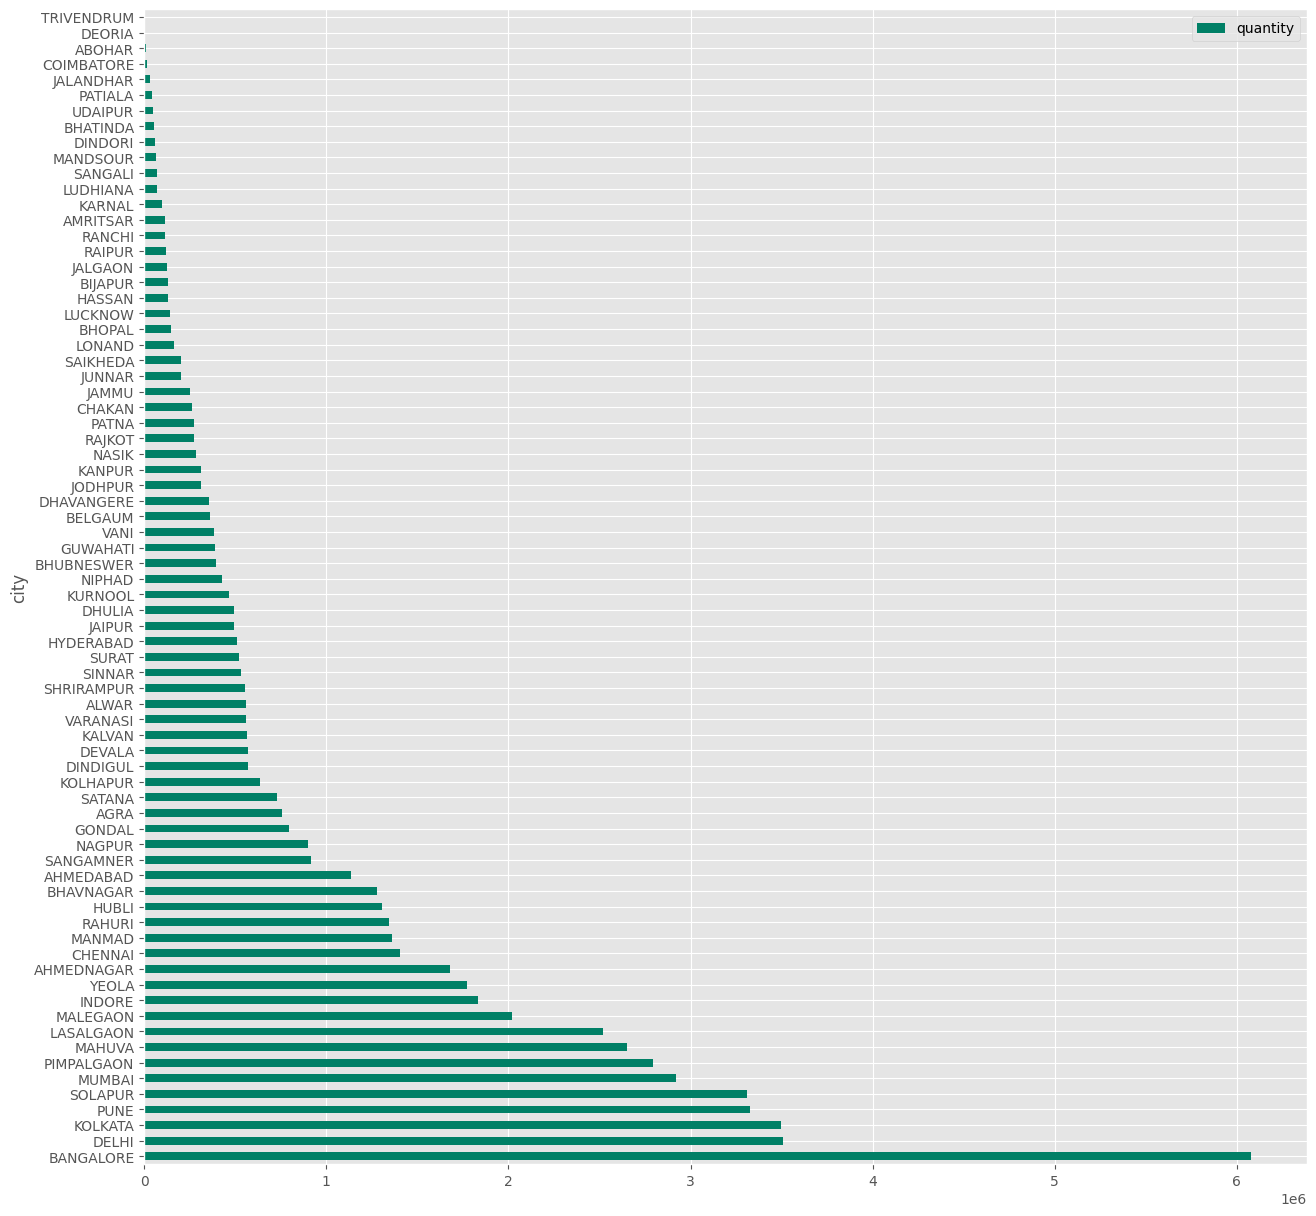

In [14]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)
df2010City.plot(kind ="barh", x = 'city', y = 'quantity', colormap='summer')

Тренд налицо.

## Задания для самостоятельного решения (статические временные данные)



### Задание 2. Штат с наибольшими продажами в 2015 году

*Определите, какой штат имел максимальные продажи в 2015 году.*

In [15]:
### your code here

### Задание 3. Визуализация продаж по штату MS в 2015 году

*Постройте график количества продаж в штате MS по всем городам в 2015 году.*


In [16]:
### your code here

## Анализ временных рядов

Теперь перейдем к анализу динамических временных данных — или, проще, — анализу временных рядов.

Как и в прошлом разделе — сделаем это на примере конкретной задачи.

### Задание 4. Разброс цен в Бангалоре по годам

Сформулируем нашу задачу следующим образом: *определите, растет ли разброс цен в Бангалоре с течением времени (с годами)?*

Здесь уже простой срез по временной отметке не поможет. Напротив — мы теперь делаем срез по городу.

In [17]:
dfBang = df[df.city == 'BANGALORE']
dfBang.head()

market    month  year  quantity  priceMin  priceMax  priceMod state  \
716  BANGALORE  January  2004    227832       916      1066       991   KNT   
717  BANGALORE  January  2005    335679       470       597       522   KNT   
718  BANGALORE  January  2006    412185       286       617       537   KNT   
719  BANGALORE  January  2007    268268       586      1167       942   KNT   
720  BANGALORE  January  2008    393806       174       671       472   KNT   

          city       date  
716  BANGALORE 2004-01-01  
717  BANGALORE 2005-01-01  
718  BANGALORE 2006-01-01  
719  BANGALORE 2007-01-01  
720  BANGALORE 2008-01-01

Для анализа временных рядов как правило всегда полезно установить дату/время в качестве индекса вашего датафрейма.

In [18]:
dfBang.index

Index([716, 717, 718, 719, 720, 721, 722, 723, 724, 725,
       ...
       852, 853, 854, 855, 856, 857, 858, 859, 860, 861],
      dtype='int64', length=146)

Убедимся, что данные отсортированы по возрастанию даты:

In [19]:
dfBang = dfBang.sort_values(by = "date")
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod state  \
716  BANGALORE   January  2004    227832       916      1066       991   KNT   
729  BANGALORE  February  2004    225133       741       870       793   KNT   
742  BANGALORE     March  2004    221952       527       586       556   KNT   
754  BANGALORE     April  2004    185150       419       518       465   KNT   
766  BANGALORE       May  2004    137390       400       516       455   KNT   

          city       date  
716  BANGALORE 2004-01-01  
729  BANGALORE 2004-02-01  
742  BANGALORE 2004-03-01  
754  BANGALORE 2004-04-01  
766  BANGALORE 2004-05-01

И теперь, собственно говоря, установим новый временной индекс:

In [20]:
dfBang.index = pd.PeriodIndex(dfBang.date, freq='M')
dfBang.drop('date', axis = 1, inplace = True)
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city  
date                      
2004-01   KNT  BANGALORE  
2004-02   KNT  BANGALORE  
2004-03   KNT  BANGALORE  
2004-04   KNT  BANGALORE  
2004-05   KNT  BANGALORE

#### Вопрос

За что отвечает параметр `freq`?

Порисуем теперь графики, чтобы посмотреть, что представляют собой наши данные.

Помня про различные типы графиков и визуализаций, воспользуемся простым линейным `plot`, поскольку, как мы и обсуждали, он лучше всего подходит для отображения временных рядов.

<Axes: xlabel='date'>

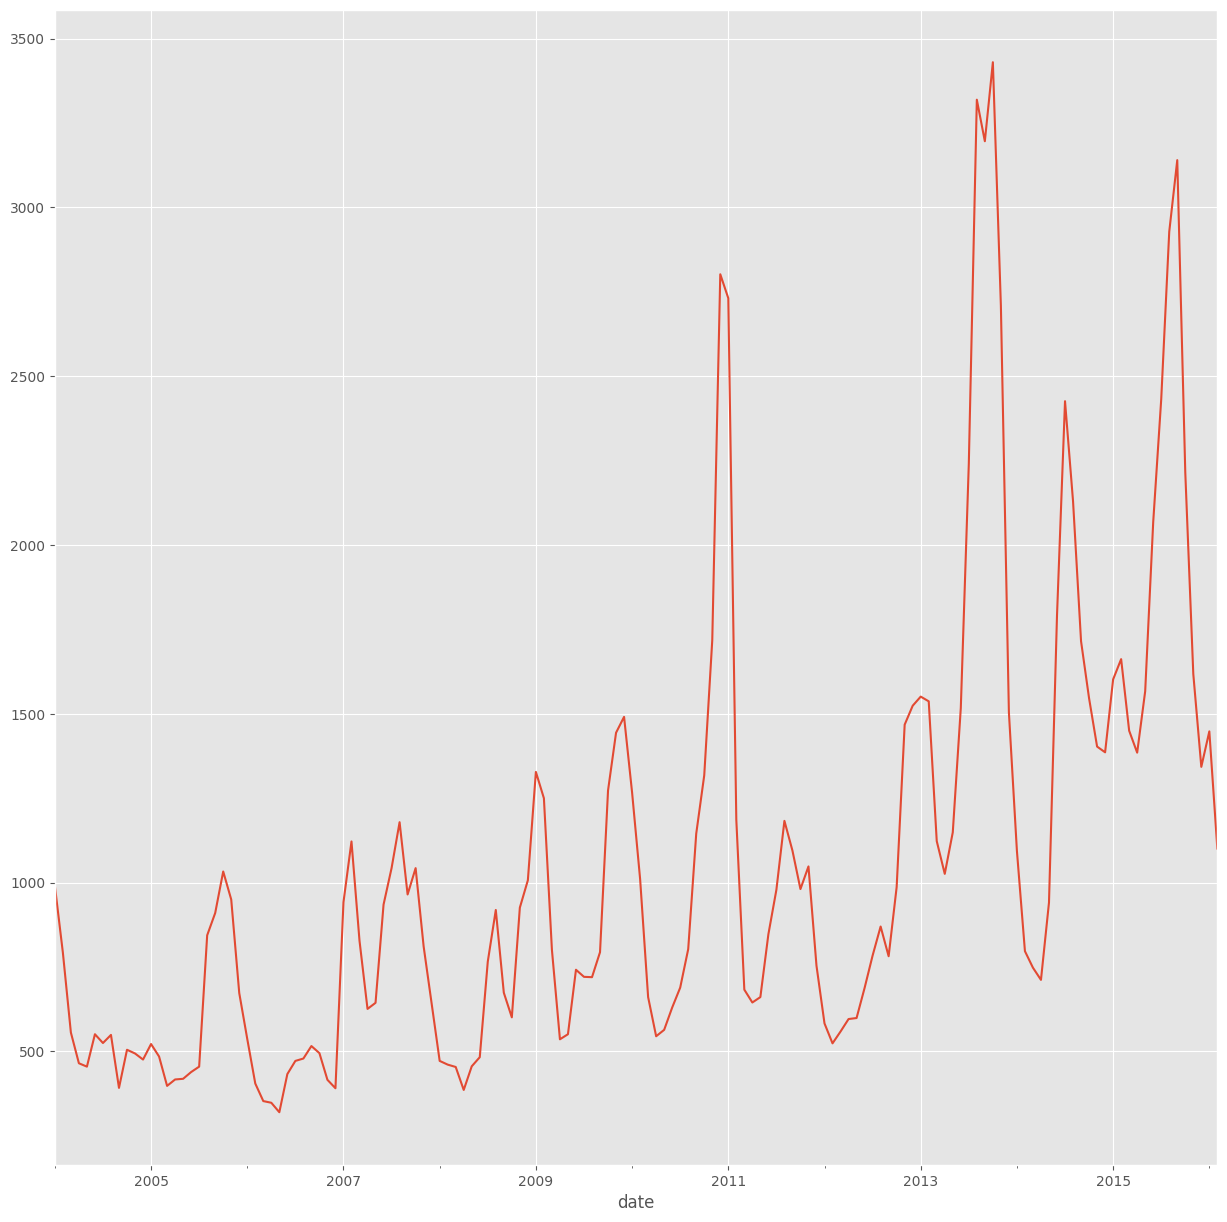

In [21]:
dfBang.priceMod.plot()

Вот оно! Это и называется временной ряд!

<Axes: xlabel='date'>

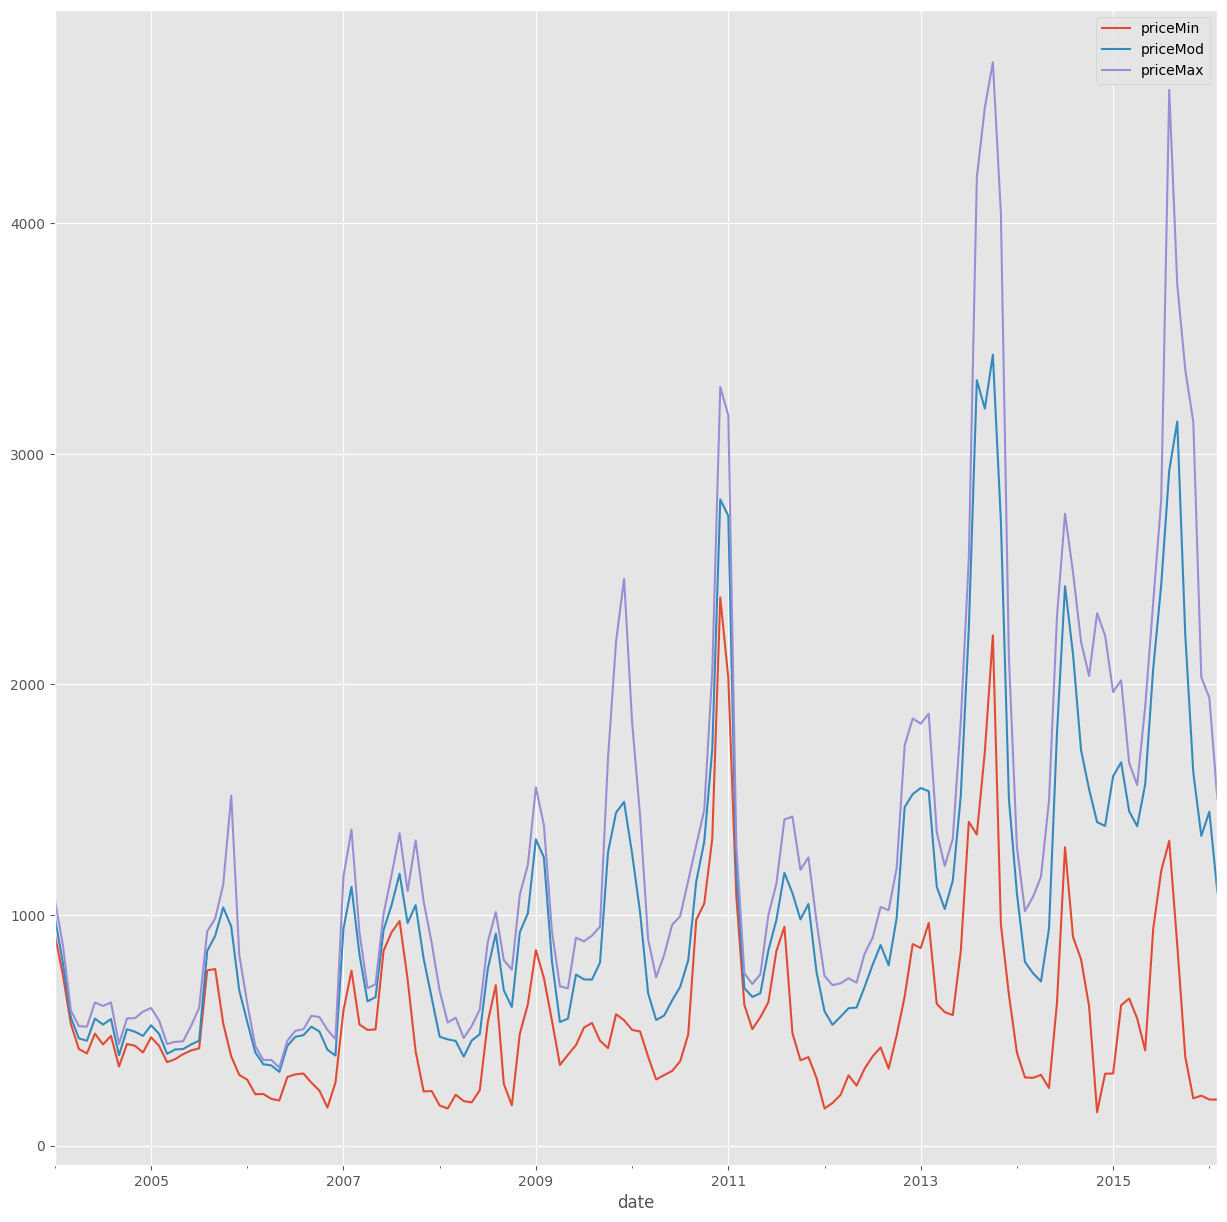

In [22]:
dfBang.plot(kind = "line", y = ['priceMin', 'priceMod', 'priceMax'])

На этот раз мы получили сразу 3 временных ряда на одних осях: минимальная, максимальная и модальная цена по годам.

Для расчета изменения (разброса) в цене, про который нас и спрашивали в задании, создадим новый атрибут, представляющий собой разницу между `priceMax` и `priceMin`.  

In [23]:
dfBang['priceDiff'] = dfBang['priceMax'] - dfBang['priceMin']

In [24]:
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city  priceDiff  
date                                 
2004-01   KNT  BANGALORE        150  
2004-02   KNT  BANGALORE        129  
2004-03   KNT  BANGALORE         59  
2004-04   KNT  BANGALORE         99  
2004-05   KNT  BANGALORE        116

Выведем теперь только интересующий нас временной ряд `priceDiff`.

<Axes: xlabel='date'>

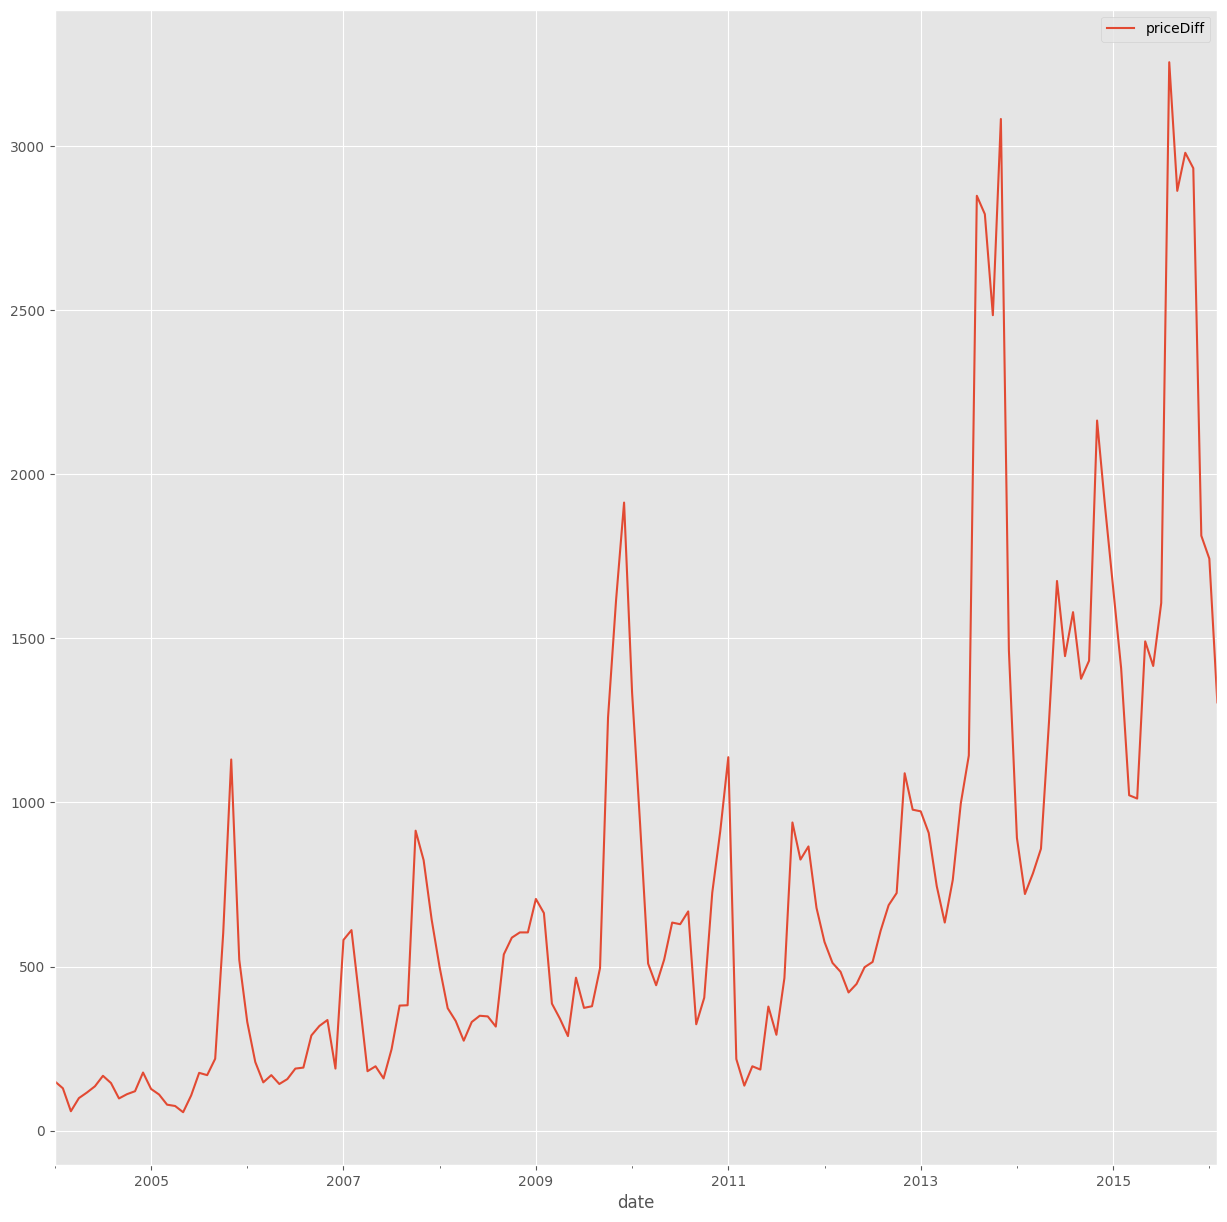

In [25]:
dfBang.plot(kind = 'line', y = 'priceDiff')

Какие выводы можно сделать?

## Сводные таблицы с временными данными

Возможность создавать сводные таблицы присутствует в электронных таблицах и других программах, оперирующих табличными данными.
Сводная таблица принимает на вход данные из отдельных столбцов и группирует их, формируя двумерную таблицу, реализующую многомерное обобщение данных.
Чтобы ощутить разницу между сводной таблицей и операцией `GroupBy`, можно представить себе сводную таблицу как многомерный вариант агрегации посредством `GroupBy`. То есть данные разделяются, преобразуются и объединяются, но при этом разделение и объединение осуществляются не по одномерному индексу, а по двумерной сетке.


![](https://pandas.pydata.org/pandas-docs/stable/_images/reshaping_pivot.png)


Попробуем применить сводные таблицы к нашим данным.

Создадим новый столбец для значения месяца, взяв его из столбца с полной датой.

In [26]:
dfBang['monthVal'] = dfBang.index.month
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city  priceDiff  monthVal  
date                                           
2004-01   KNT  BANGALORE        150         1  
2004-02   KNT  BANGALORE        129         2  
2004-03   KNT  BANGALORE         59         3  
2004-04   KNT  BANGALORE         99         4  
2004-05   KNT  BANGALORE        116         5

Cоздадим сводную таблицу по недавно созданному нами столбцу `priceDiff` с месяцами по строкам и годами по столбцам.

In [27]:
dfBangPivot = pd.pivot_table(dfBang, values = "priceDiff",
                             columns = "year", index = "monthVal")

dfBangPivot

year       2004    2005   2006   2007   2008    2009    2010    2011    2012  \
monthVal                                                                       
1        150.00  127.00 331.00 581.00 497.00  706.00 1335.00 1138.00  575.00   
2        129.00  110.00 209.00 611.00 373.00  663.00  934.00  218.00  511.00   
3         59.00   79.00 147.00 398.00 334.00  387.00  509.00  137.00  484.00   
4         99.00   75.00 169.00 181.00 274.00  341.00  443.00  196.00  421.00   
5        116.00   56.00 142.00 196.00 331.00  288.00  521.00  186.00  447.00   
6        135.00  107.00 157.00 159.00 350.00  466.00  634.00  378.00  498.00   
7        167.00  176.00 189.00 248.00 348.00  374.00  629.00  292.00  514.00   
8        145.00  169.00 192.00 381.00 317.00  379.00  668.00  465.00  609.00   
9         98.00  219.00 290.00 382.00 537.00  495.00  324.00  939.00  687.00   
10       111.00  602.00 319.00 914.00 588.00 1259.00  405.00  826.00  724.00   
11       120.00 1131.00 337.00 824.00 604.00 1616.00  725.00  866.00 1089.00   
12       177.00  521.00 189.00 643.00 604.00 1914.00  913.00  679.00  978.00   

year        2013    2014    2015    2016  
monthVal                                  
1         973.00  892.00 1654.00 1743.00  
2         907.00  721.00 1409.00 1305.00  
3         745.00  784.00 1022.00     NaN  
4         634.00  859.00 1012.00     NaN  
5         764.00 1245.00 1491.00     NaN  
6         997.00 1675.00 1416.00     NaN  
7        1143.00 1446.00 1608.00     NaN  
8        2849.00 1580.00 3256.00     NaN  
9        2793.00 1377.00 2864.00     NaN  
10       2485.00 1432.00 2980.00     NaN  
11       3083.00 2164.00 2933.00     NaN  
12       1463.00 1900.00 1813.00     NaN

#### Вопрос

Почему в таблице есть какие-то NaN'ы?

Визуализуруем тренды по годам:

<Axes: xlabel='monthVal'>

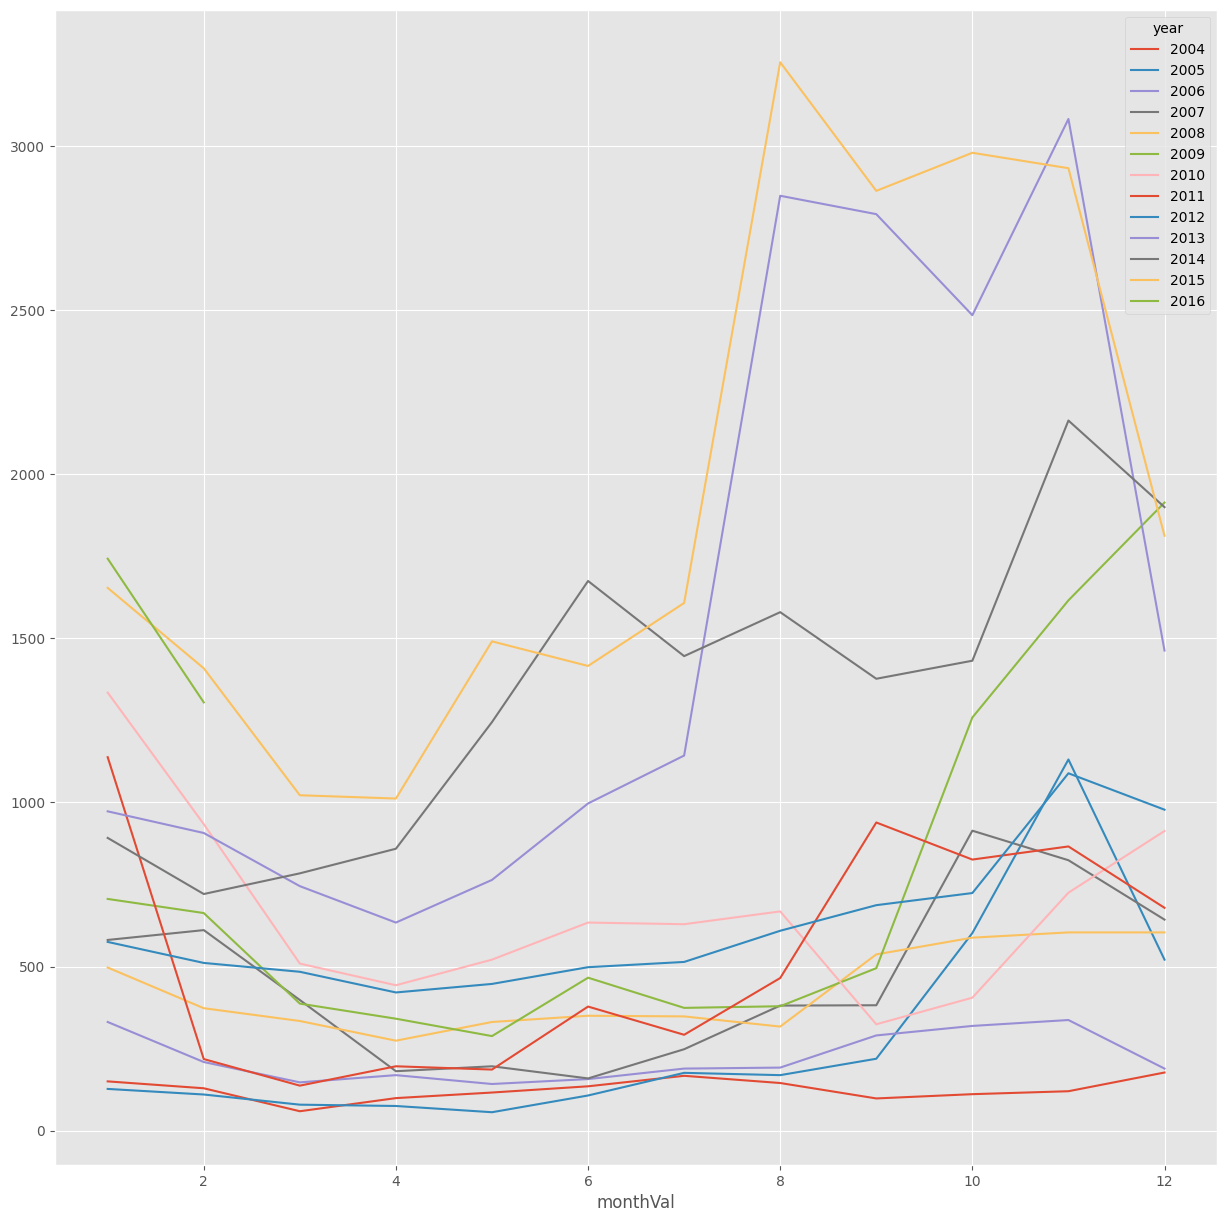

In [28]:
plt.style.use('ggplot')
dfBangPivot.plot()

Какие выводы можно сделать?

#### Вопрос

Какой еще тип визуализации здесь неплохо бы подошел?

## Задание для самостоятельного решения (сводные таблицы)

### Задание 5. Сводная таблица по штатам и годам

*Выведите сводную таблицу со значениями `quantity` по штатам и годам.*

In [29]:
### your code here

## Прогнозирование временных рядов

Наконец, мы готовы перейти от анализа к прогнозированию временных рядов. Какие модели мы можем рассмотреть в этом контексте?

1. Простой прогноз
      
      1.1. Прогнозирование средним (Mean Constant Model)

      1.2. Линейная модель (Linear Trend Model)

      1.3. Линейная модель с регрессией (Linear Regression Model)
2. Выделение тренда и сезонности
3. Анализ стационарности ряда
4. ARIMA

Итак, приступим к работе. Будем для консистентности анализировать данные по знакомому нам городу Бангалор.

In [30]:
dfBang.head()

market     month  year  quantity  priceMin  priceMax  priceMod  \
date                                                                         
2004-01  BANGALORE   January  2004    227832       916      1066       991   
2004-02  BANGALORE  February  2004    225133       741       870       793   
2004-03  BANGALORE     March  2004    221952       527       586       556   
2004-04  BANGALORE     April  2004    185150       419       518       465   
2004-05  BANGALORE       May  2004    137390       400       516       455   

        state       city  priceDiff  monthVal  
date                                           
2004-01   KNT  BANGALORE        150         1  
2004-02   KNT  BANGALORE        129         2  
2004-03   KNT  BANGALORE         59         3  
2004-04   KNT  BANGALORE         99         4  
2004-05   KNT  BANGALORE        116         5

Удалим лишние столбцы:

In [31]:
dfBang = dfBang[['quantity', 'priceMod']]

In [32]:
dfBang.shape

(146, 2)

In [33]:
dfBang.head()

quantity  priceMod
date                       
2004-01    227832       991
2004-02    225133       793
2004-03    221952       556
2004-04    185150       465
2004-05    137390       455

<Axes: xlabel='date'>

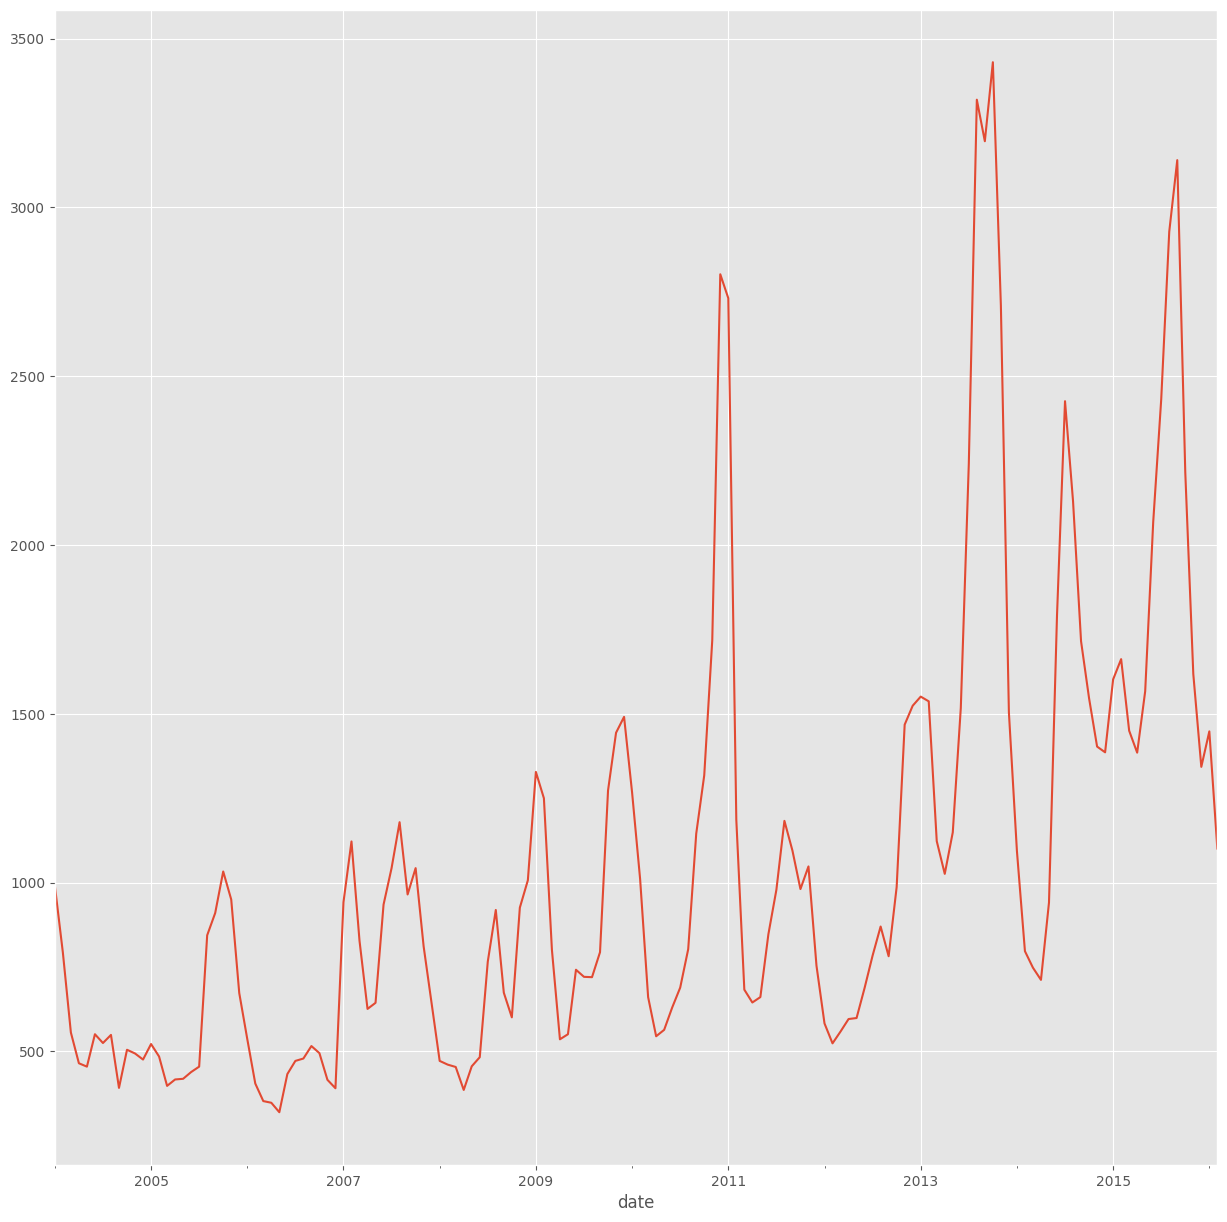

In [34]:
dfBang.priceMod.plot()

<Axes: xlabel='date'>

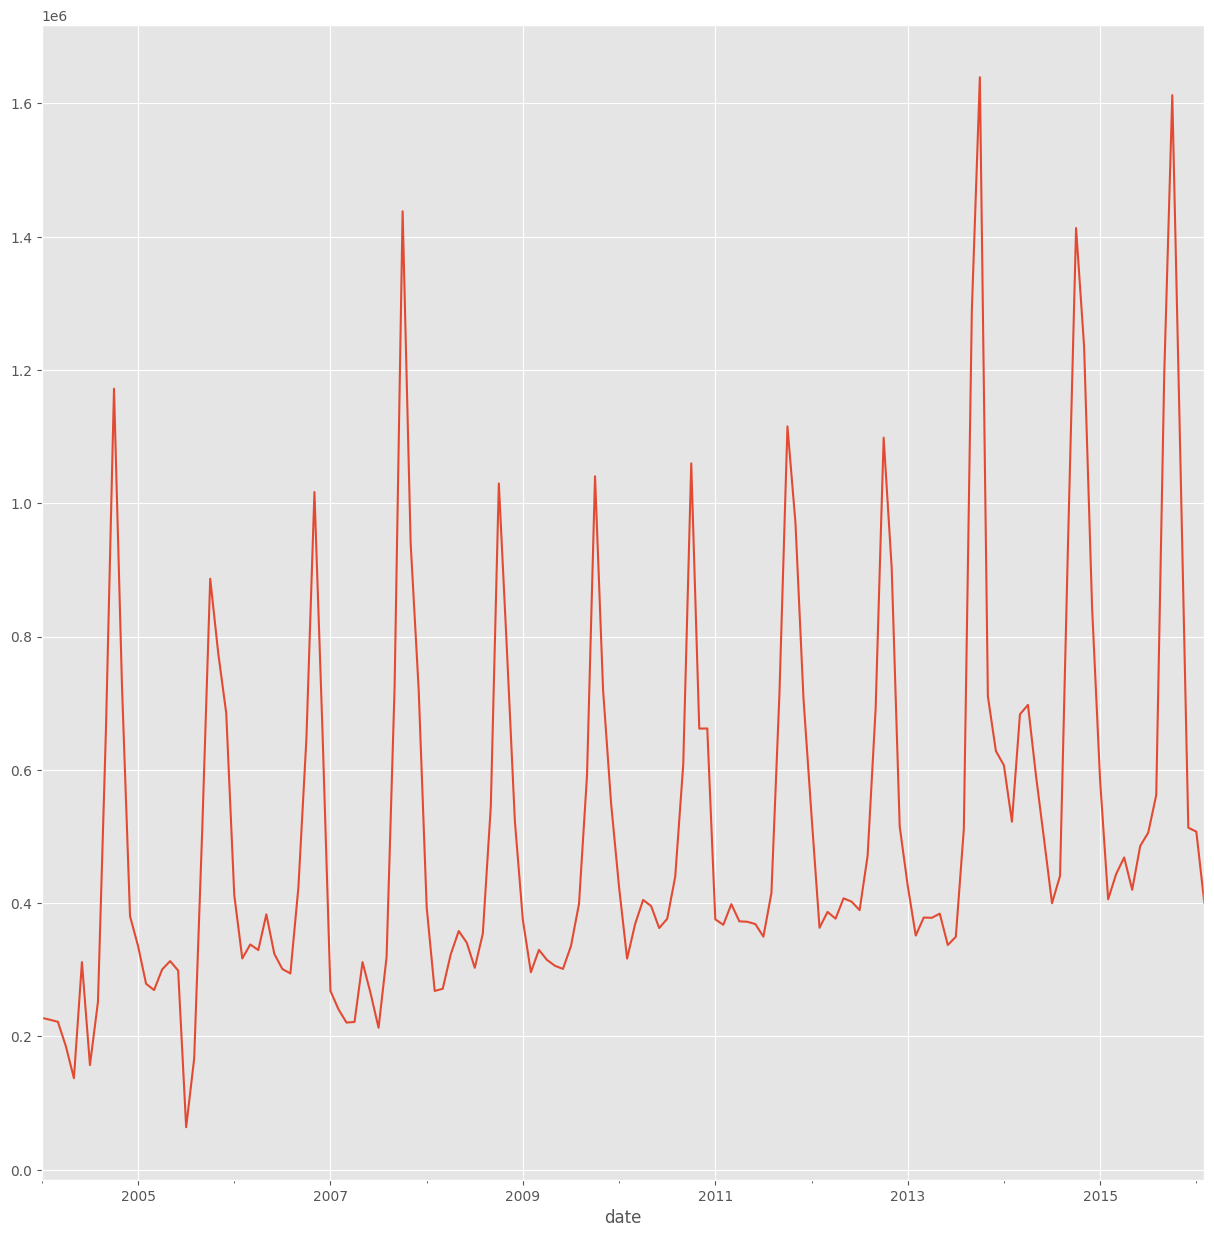

In [35]:
dfBang.quantity.plot()

### Логарифмическое преобразование данных
Логарифмирование часто помогает стабилизировать разброс значений во временных рядах

<Axes: ylabel='Frequency'>

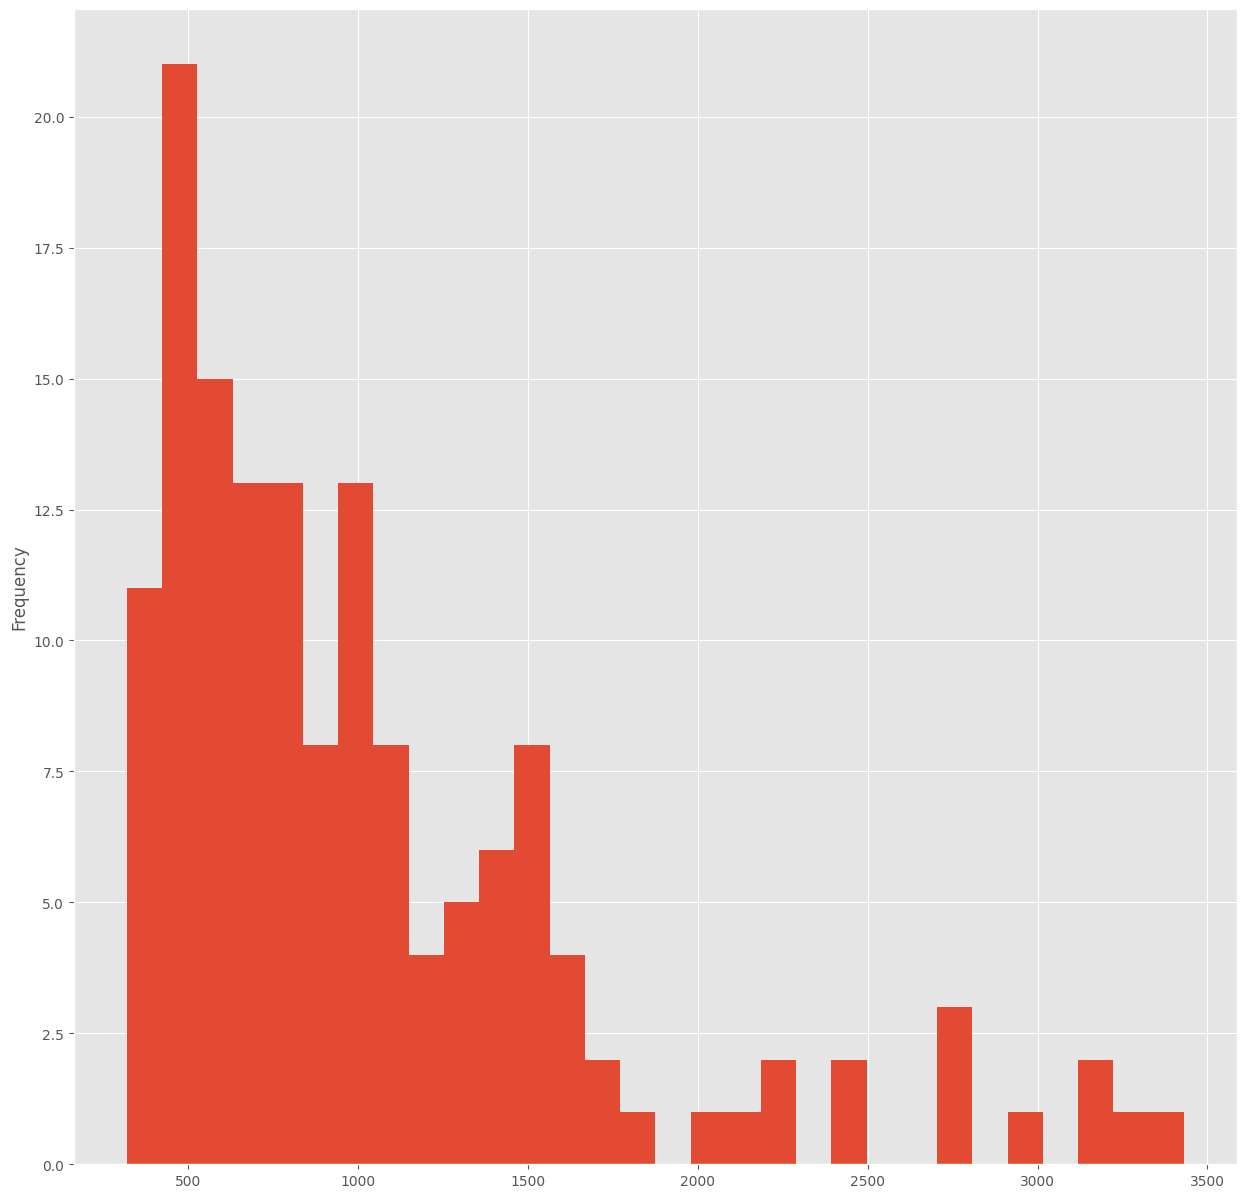

In [36]:
dfBang.priceMod.plot(kind = "hist", bins = 30)

При визуализации гистограммы можем заметить, что есть данные, далеко отстающие от среднего значения, что может искажать модель регрессии. Наша задача — минимизировать влияние таких данных. Желательно, не исключая их. В этом случае самый распространенный вариант действия — логарифмирование переменной.

In [37]:
dfBang['priceModLog'] = np.log(dfBang.priceMod)
dfBang.head()

quantity  priceMod  priceModLog
date                                    
2004-01    227832       991         6.90
2004-02    225133       793         6.68
2004-03    221952       556         6.32
2004-04    185150       465         6.14
2004-05    137390       455         6.12

<Axes: ylabel='Frequency'>

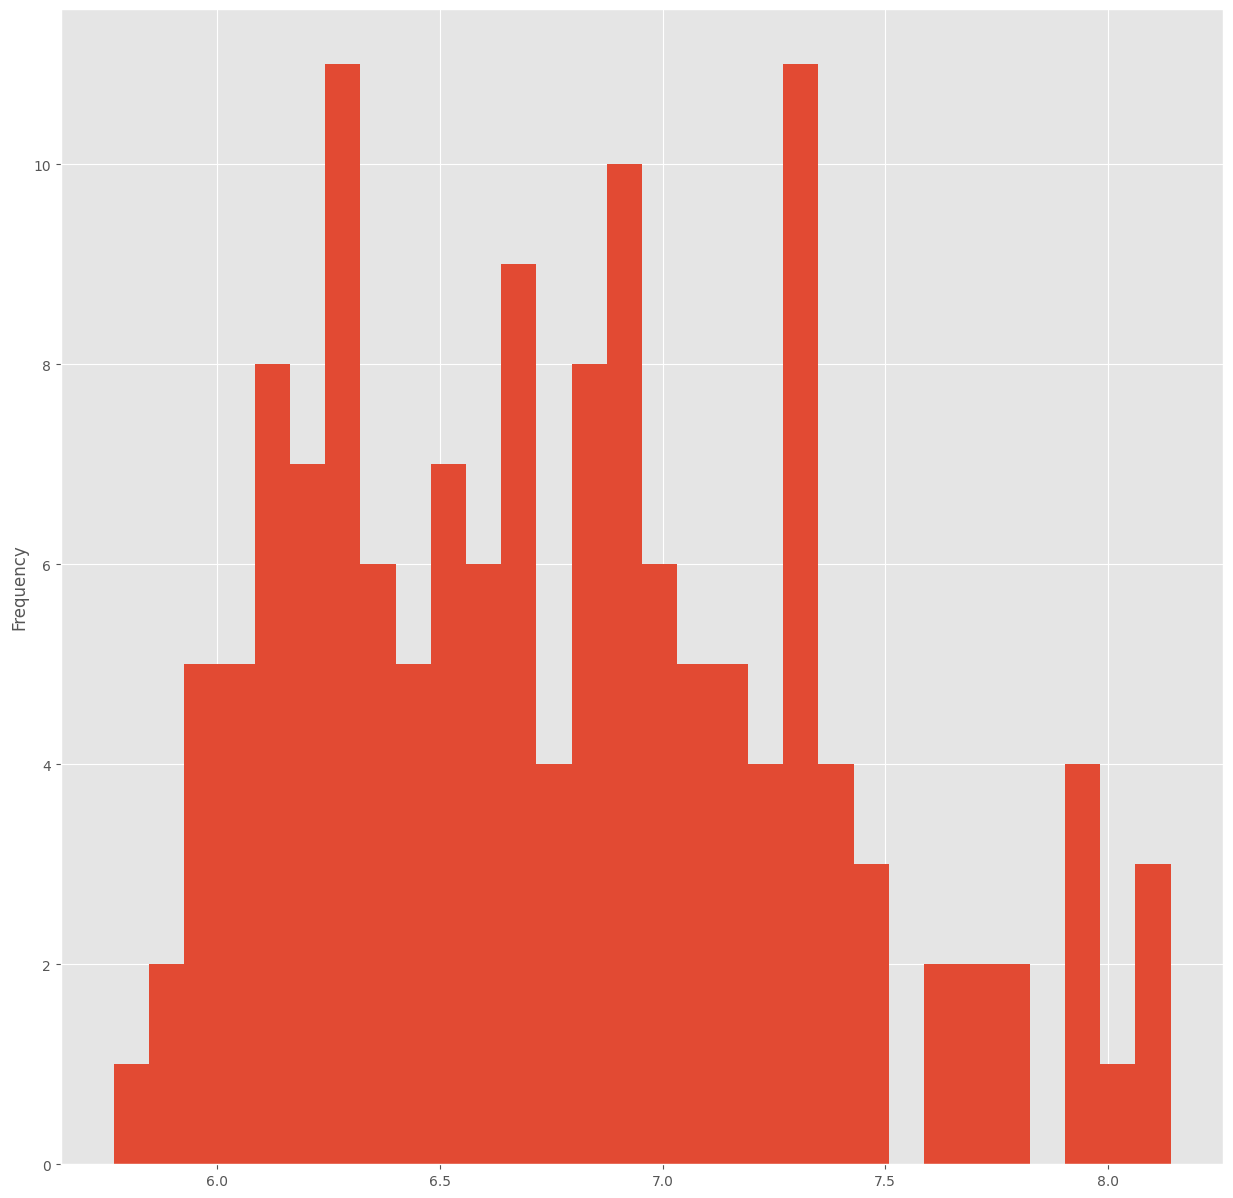

In [38]:
dfBang.priceModLog.plot(kind = "hist", bins = 30)

<Axes: xlabel='date'>

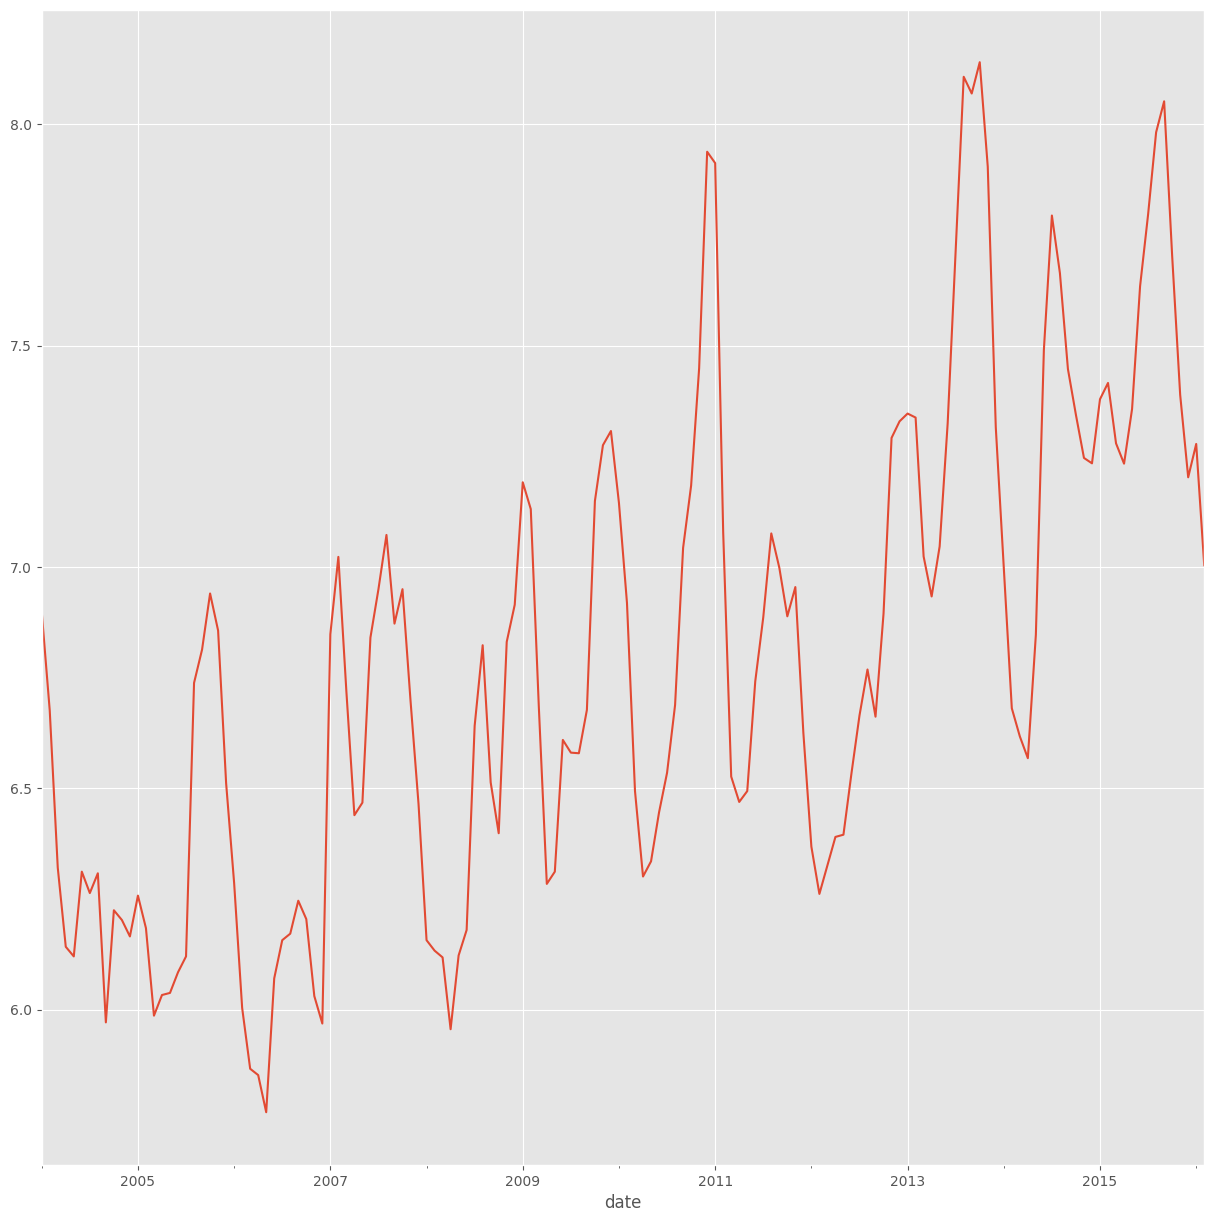

In [39]:
dfBang.priceModLog.plot()

Как можно видеть, мы получили заметно более хорошие данные!

## Прогнозирование средним

Для начала осуществим простое прогнозирование средним

In [40]:
model_mean_pred = dfBang.priceModLog.mean()

In [41]:
# Запишем это значение в priceMean
dfBang["priceMean"] = np.exp(model_mean_pred)

<Axes: xlabel='date'>

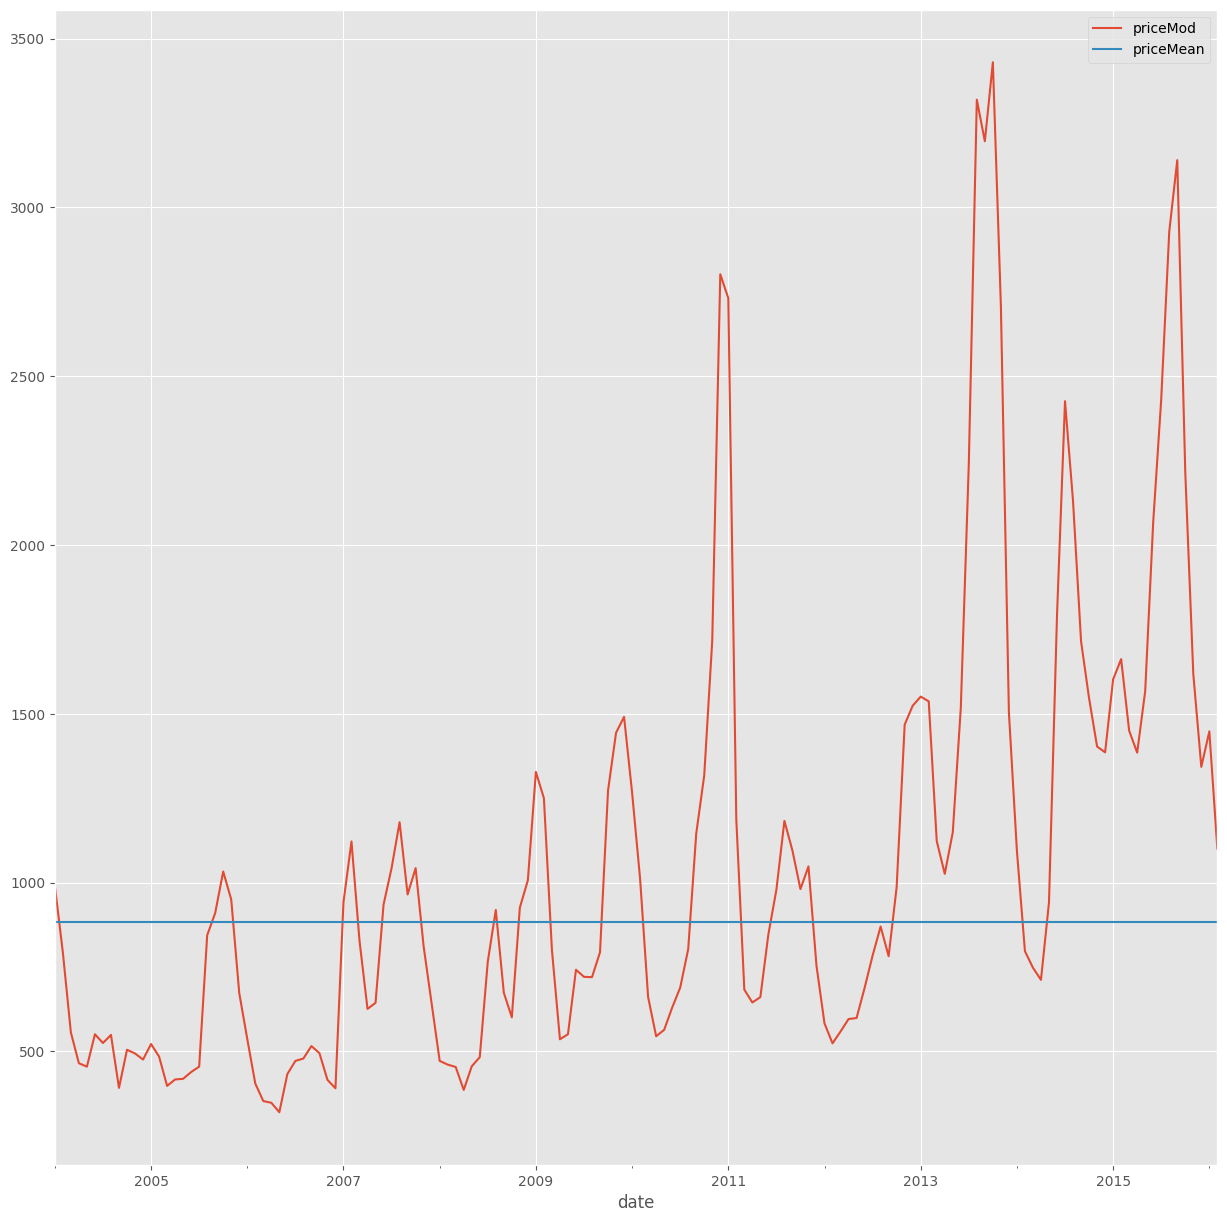

In [42]:
dfBang.plot(kind="line", y = ["priceMod", "priceMean"])

#### Вопрос

Как теперь понять, хорошая ли у нас модель?

#### Пояснение

Чтобы обучать регрессионные модели прогнозирования временных рядов, нужно определиться, как именно измеряется качество предсказаний. То есть, проще говоря, определить какую-то метрику качества.

Давайте мы с вами будем использовать отчасти знакомую нам метрику RMSE (Root Mean Squared Error) — корень среднеквадратичного отклонения.

$$RMSE =  \sqrt{ \Sigma (\hat{y} - y)^2/n} $$

где $\hat{y}$ это предсказанное значение $y$.

In [43]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [44]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

np.float64(683.9533483996255)

In [45]:
dfBangResults = pd.DataFrame(columns = ["Model", "RMSE"])
dfBangResults.head()

Empty DataFrame
Columns: [Model, RMSE]
Index: []

In [46]:
dfBangResults.loc[0,"Model"] = "Mean"
dfBangResults.loc[0,"RMSE"] = model_mean_RMSE
dfBangResults.head()

Model   RMSE
0  Mean 683.95

## Задание для самостоятельного решения (прогнозирование средним)



### Задание 6. Прогнозирование средним

*Постройте модель прогнозирования средним для величины `quantity`.*

In [47]:
## your code here

## Линейная модель

Построим линейную зависимость между `priceModLog` и `time`. Уравнение регрессии строится с помощью метода наимменьших квадратов.

In [48]:
dfBang = dfBang.reset_index()
dfBang.head()

date  quantity  priceMod  priceModLog  priceMean
0  2004-01    227832       991         6.90     884.57
1  2004-02    225133       793         6.68     884.57
2  2004-03    221952       556         6.32     884.57
3  2004-04    185150       465         6.14     884.57
4  2004-05    137390       455         6.12     884.57

Вычисляем разницу в месяцах с минимальной датой

In [49]:
min_date = dfBang.date.min()

dfBang['months_since_min'] = dfBang.date.apply(lambda x: (x - min_date).n)

dfBang.head()

date  quantity  priceMod  priceModLog  priceMean  months_since_min
0  2004-01    227832       991         6.90     884.57                 0
1  2004-02    225133       793         6.68     884.57                 1
2  2004-03    221952       556         6.32     884.57                 2
3  2004-04    185150       465         6.14     884.57                 3
4  2004-05    137390       455         6.12     884.57                 4

In [50]:
model_linear = smf.ols('priceModLog ~ months_since_min', data = dfBang).fit()

In [51]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     139.8
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           5.75e-23
Time:                        15:35:30   Log-Likelihood:                -72.317
No. Observations:                 146   AIC:                             148.6
Df Residuals:                     144   BIC:                             154.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.1121      0.066     92.830      0.000       5.982       6.242
months_since_min     0.0093      0.001     11.823      0.000       0.008       0.011
==============================================================================
Omnibus:                        4.750   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.739
Skew:                           0.405   Prob(JB):                       0.0935
Kurtosis:                       2.648   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Выведем параметры нашей линейной модели

In [52]:
model_linear.params

Intercept          6.11
months_since_min   0.01
dtype: float64

In [53]:
model_linear_pred = model_linear.predict()

In [54]:
model_linear_pred

array([6.11210813, 6.12139074, 6.13067334, 6.13995594, 6.14923855,
       6.15852115, 6.16780376, 6.17708636, 6.18636896, 6.19565157,
       6.20493417, 6.21421678, 6.22349938, 6.23278198, 6.24206459,
       6.25134719, 6.2606298 , 6.2699124 , 6.279195  , 6.28847761,
       6.29776021, 6.30704282, 6.31632542, 6.32560802, 6.33489063,
       6.34417323, 6.35345583, 6.36273844, 6.37202104, 6.38130365,
       6.39058625, 6.39986885, 6.40915146, 6.41843406, 6.42771667,
       6.43699927, 6.44628187, 6.45556448, 6.46484708, 6.47412969,
       6.48341229, 6.49269489, 6.5019775 , 6.5112601 , 6.52054271,
       6.52982531, 6.53910791, 6.54839052, 6.55767312, 6.56695572,
       6.57623833, 6.58552093, 6.59480354, 6.60408614, 6.61336874,
       6.62265135, 6.63193395, 6.64121656, 6.65049916, 6.65978176,
       6.66906437, 6.67834697, 6.68762958, 6.69691218, 6.70619478,
       6.71547739, 6.72475999, 6.7340426 , 6.7433252 , 6.7526078 ,
       6.76189041, 6.77117301, 6.78045561, 6.78973822, 6.79902

In [55]:
dfBang["priceLinear"] = np.exp(model_linear_pred)

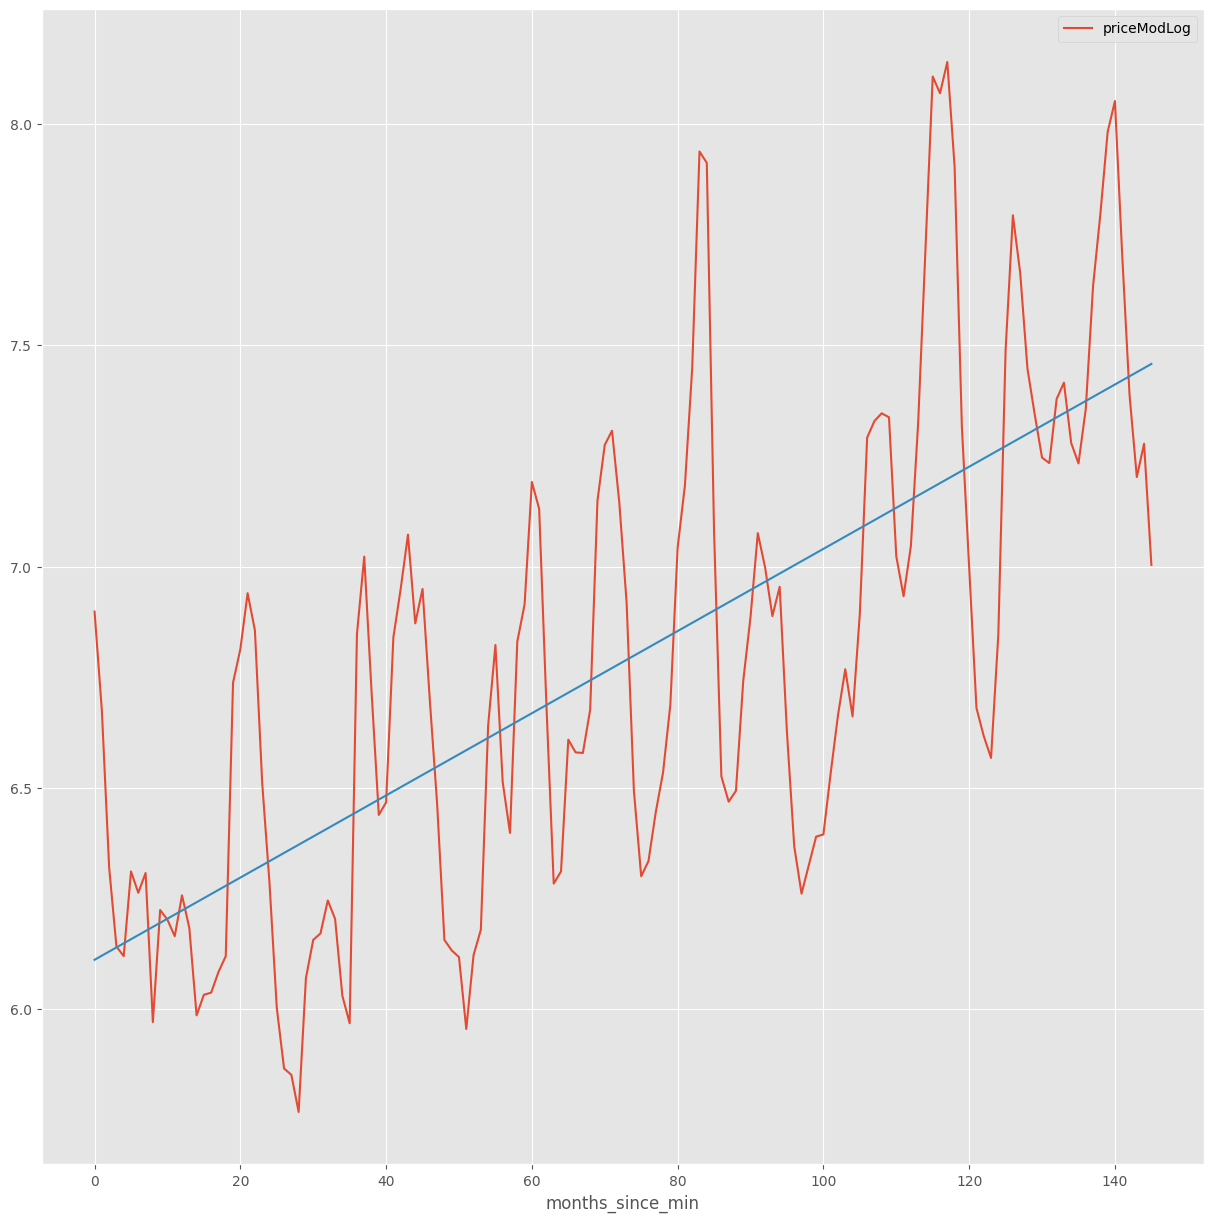

In [56]:
dfBang.plot(kind="line", x="months_since_min", y = "priceModLog")
plt.plot(dfBang.months_since_min, model_linear_pred, '-')

<Axes: >

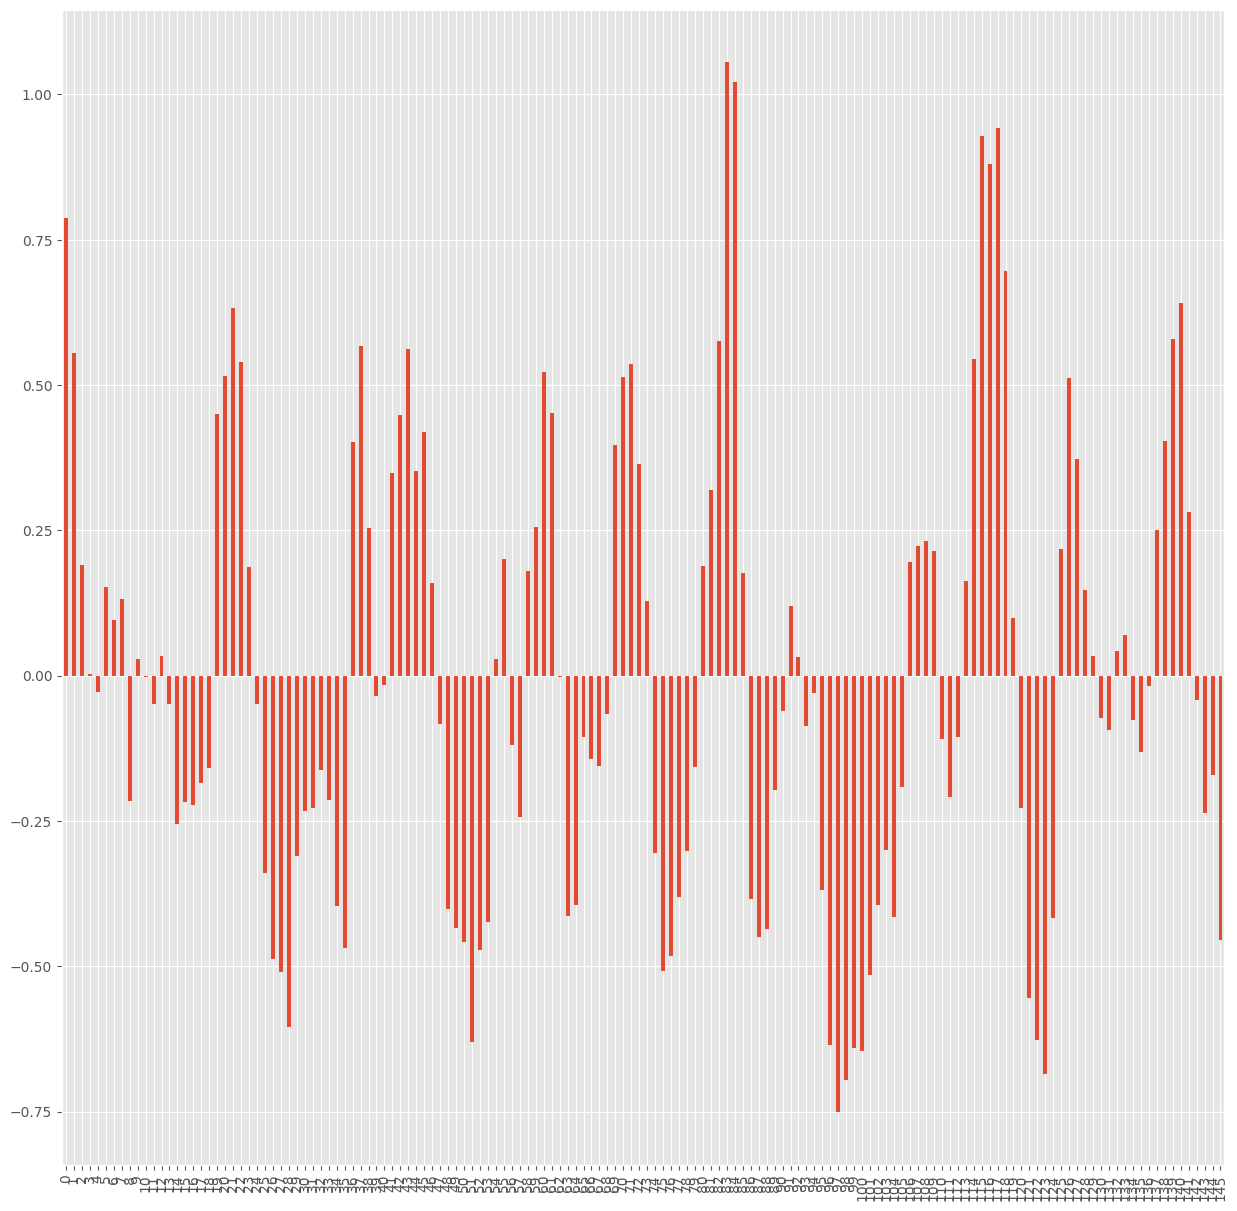

In [57]:
model_linear.resid.plot(kind = "bar")

Посчитаем ошибку RMSE на линейной модели:

In [58]:
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

np.float64(518.5236075841487)

In [59]:
dfBangResults.loc[1,"Model"] = "Linear"
dfBangResults.loc[1,"RMSE"] = model_linear_RMSE
dfBangResults.head()

Model   RMSE
0    Mean 683.95
1  Linear 518.52

## Задание для самостоятельного решения (линейная модель)



### Задание 7. Линейная модель

*Постройте линейную модель для величины `quantity`*

In [60]:
### your code here

## Линейная модель с регрессией

In [61]:
dfBang.tail()

date  quantity  priceMod  priceModLog  priceMean  months_since_min  \
141  2015-10   1612160      2215         7.70     884.57               141   
142  2015-11   1071872      1618         7.39     884.57               142   
143  2015-12    513186      1343         7.20     884.57               143   
144  2016-01    507223      1448         7.28     884.57               144   
145  2016-02    400359      1101         7.00     884.57               145   

     priceLinear  
141      1670.63  
142      1686.21  
143      1701.93  
144      1717.81  
145      1733.83

In [62]:
## Построим регрессию, используя несколько переменных months_since_min и np.log(quantity)
model_linear_quantity = smf.ols('priceModLog ~ months_since_min + np.log(quantity)', data = dfBang).fit()

In [63]:
model_linear_quantity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     74.16
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           8.00e-23
Time:                        15:35:43   Log-Likelihood:                -69.892
No. Observations:                 146   AIC:                             145.8
Df Residuals:                     143   BIC:                             154.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1813      0.881      4.746      0.000       2.440       5.923
months_since_min     0.0084      0.001      9.774      0.000       0.007       0.010
np.log(quantity)     0.1529      0.070      2.198      0.030       0.015       0.290
==============================================================================
Omnibus:                        5.097   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.952
Skew:                           0.403   Prob(JB):                       0.0841
Kurtosis:                       2.593   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
dfBang.head()

date  quantity  priceMod  priceModLog  priceMean  months_since_min  \
0  2004-01    227832       991         6.90     884.57                 0   
1  2004-02    225133       793         6.68     884.57                 1   
2  2004-03    221952       556         6.32     884.57                 2   
3  2004-04    185150       465         6.14     884.57                 3   
4  2004-05    137390       455         6.12     884.57                 4   

   priceLinear  
0       451.29  
1       455.50  
2       459.75  
3       464.03  
4       468.36

In [65]:
model_linear_quantity.predict().shape

(146,)

In [66]:
dfBang["priceLinearQuantity"] = np.exp(model_linear_quantity.predict())

In [67]:
model_linear_q_pred = model_linear_quantity.predict()

<Axes: xlabel='months_since_min'>

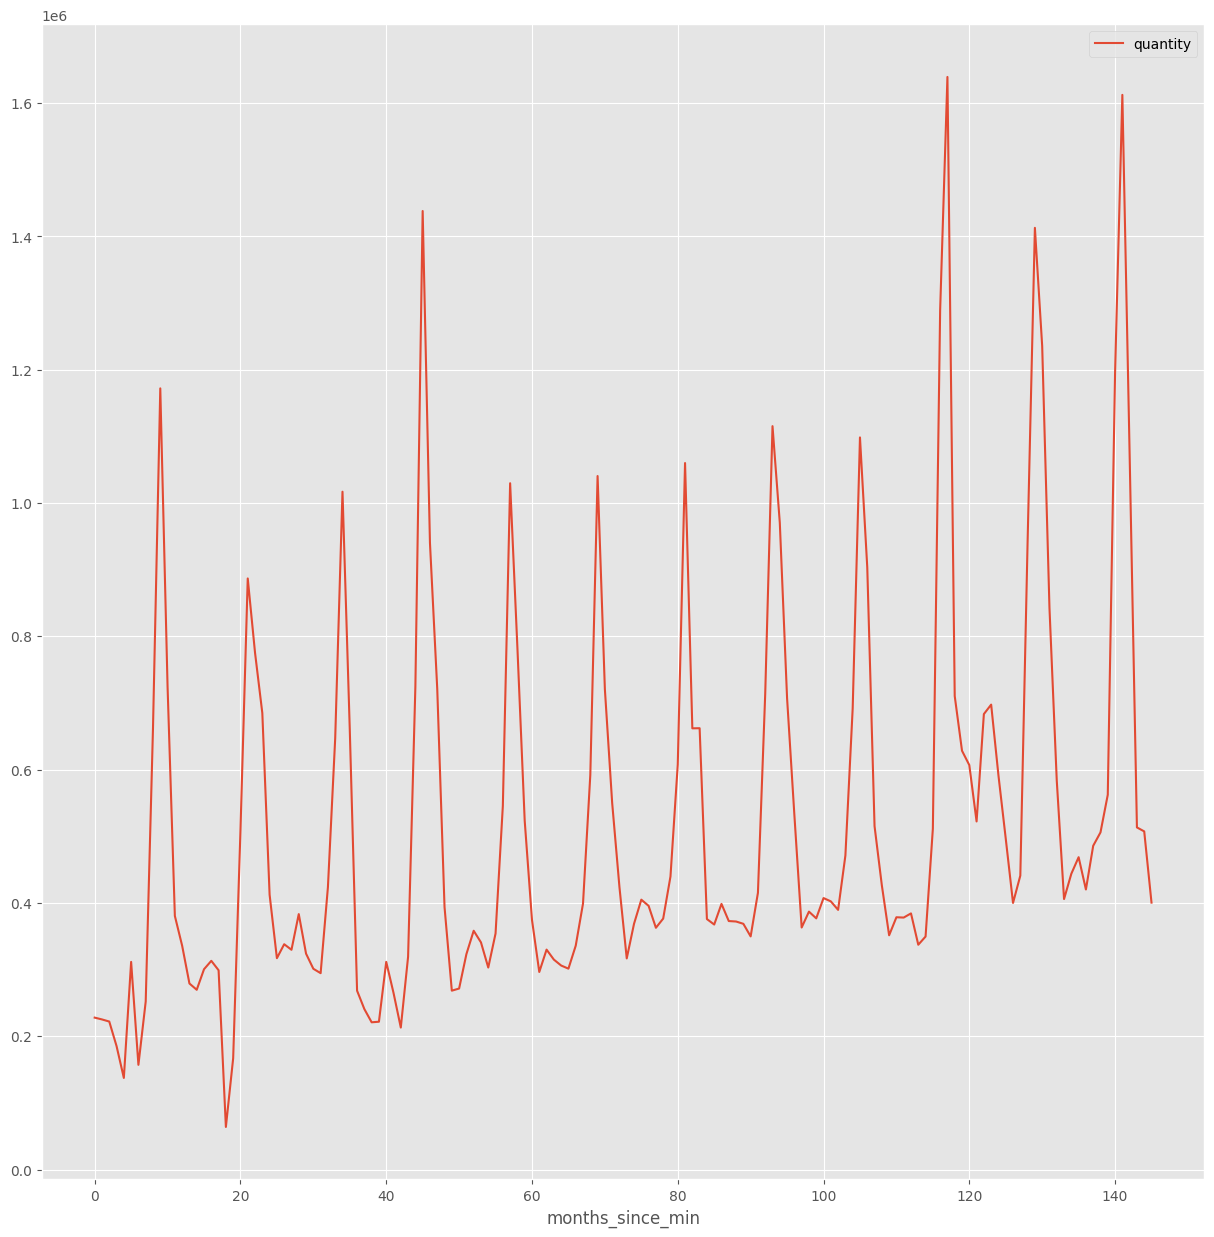

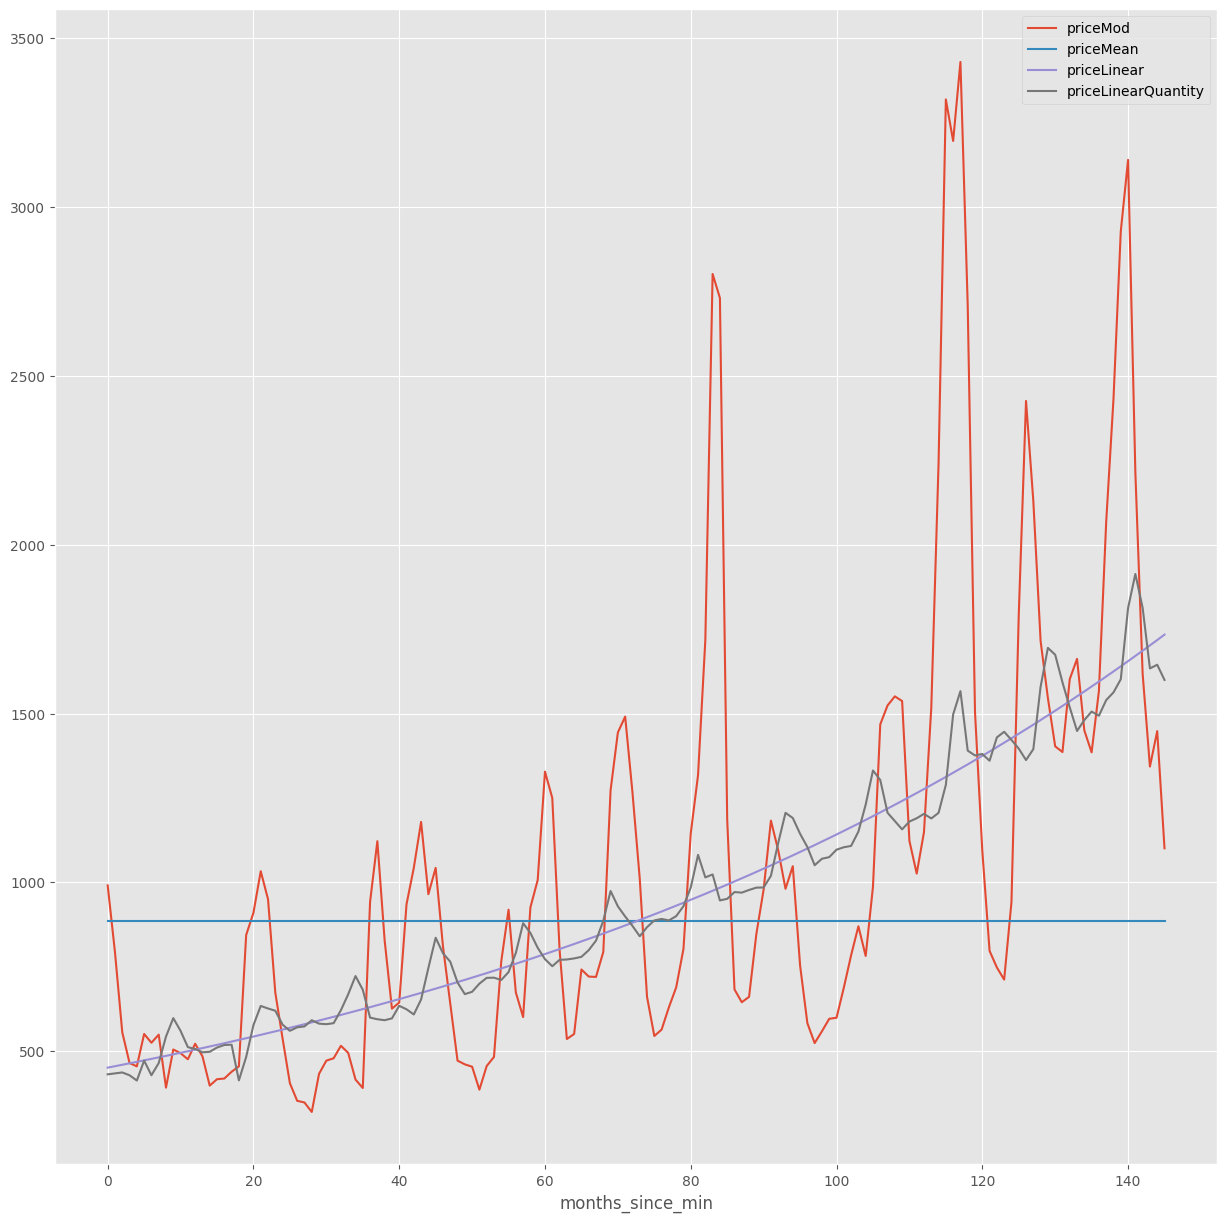

In [68]:
dfBang.plot(kind = "line", x="months_since_min", y = "quantity")
dfBang.plot(kind="line", x="months_since_min", y = ["priceMod", "priceMean",
                                             "priceLinear", "priceLinearQuantity"])

## Задание для самостоятельного решения (линейная модель с регрессией)



### Задание 8. Линейная модель с регрессией

*Постройте линейную модель с регрессией для величины `quantity`*

In [69]:
### your code here

## Прогнозирование в будущее

Также мы можем обучить нашу модель на части выборки, чтобы осуществить прогноз в будущее. Для оставшихся данных в начале сделаем прогноз, затем оценим, насколько он был точный

In [70]:
dfBang.tail()

date  quantity  priceMod  priceModLog  priceMean  months_since_min  \
141  2015-10   1612160      2215         7.70     884.57               141   
142  2015-11   1071872      1618         7.39     884.57               142   
143  2015-12    513186      1343         7.20     884.57               143   
144  2016-01    507223      1448         7.28     884.57               144   
145  2016-02    400359      1101         7.00     884.57               145   

     priceLinear  priceLinearQuantity  
141      1670.63              1913.49  
142      1686.21              1812.99  
143      1701.93              1633.68  
144      1717.81              1644.59  
145      1733.83              1599.63

In [71]:
model_linear_quantity = smf.ols('priceModLog ~ months_since_min + np.log(quantity)', data = dfBang.iloc[:-15, :]).fit()
model_linear_quantity.predict(dfBang.iloc[-15:, :])

131   7.33
132   7.29
133   7.24
134   7.26
135   7.28
136   7.27
137   7.30
138   7.31
139   7.34
140   7.45
141   7.51
142   7.45
143   7.36
144   7.36
145   7.34
dtype: float64

In [72]:
prediction = np.exp(model_linear_quantity.predict(dfBang.iloc[-15:, :]).values)

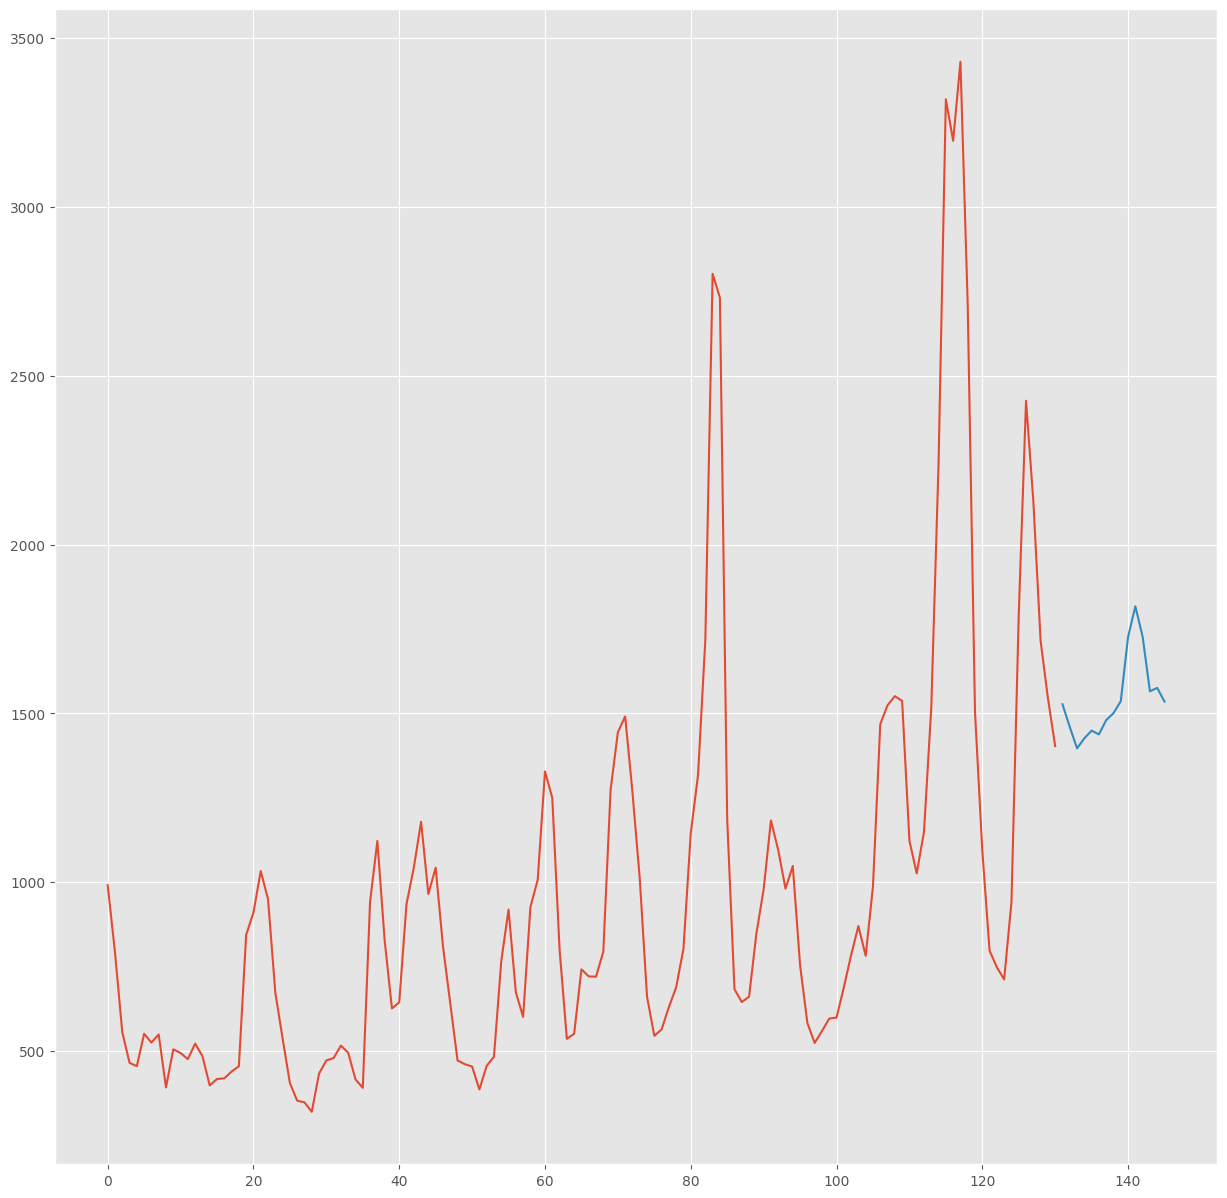

In [73]:
plt.plot(dfBang.months_since_min[:-15], dfBang['priceMod'][:-15])
plt.plot(dfBang.months_since_min[-15:], prediction)

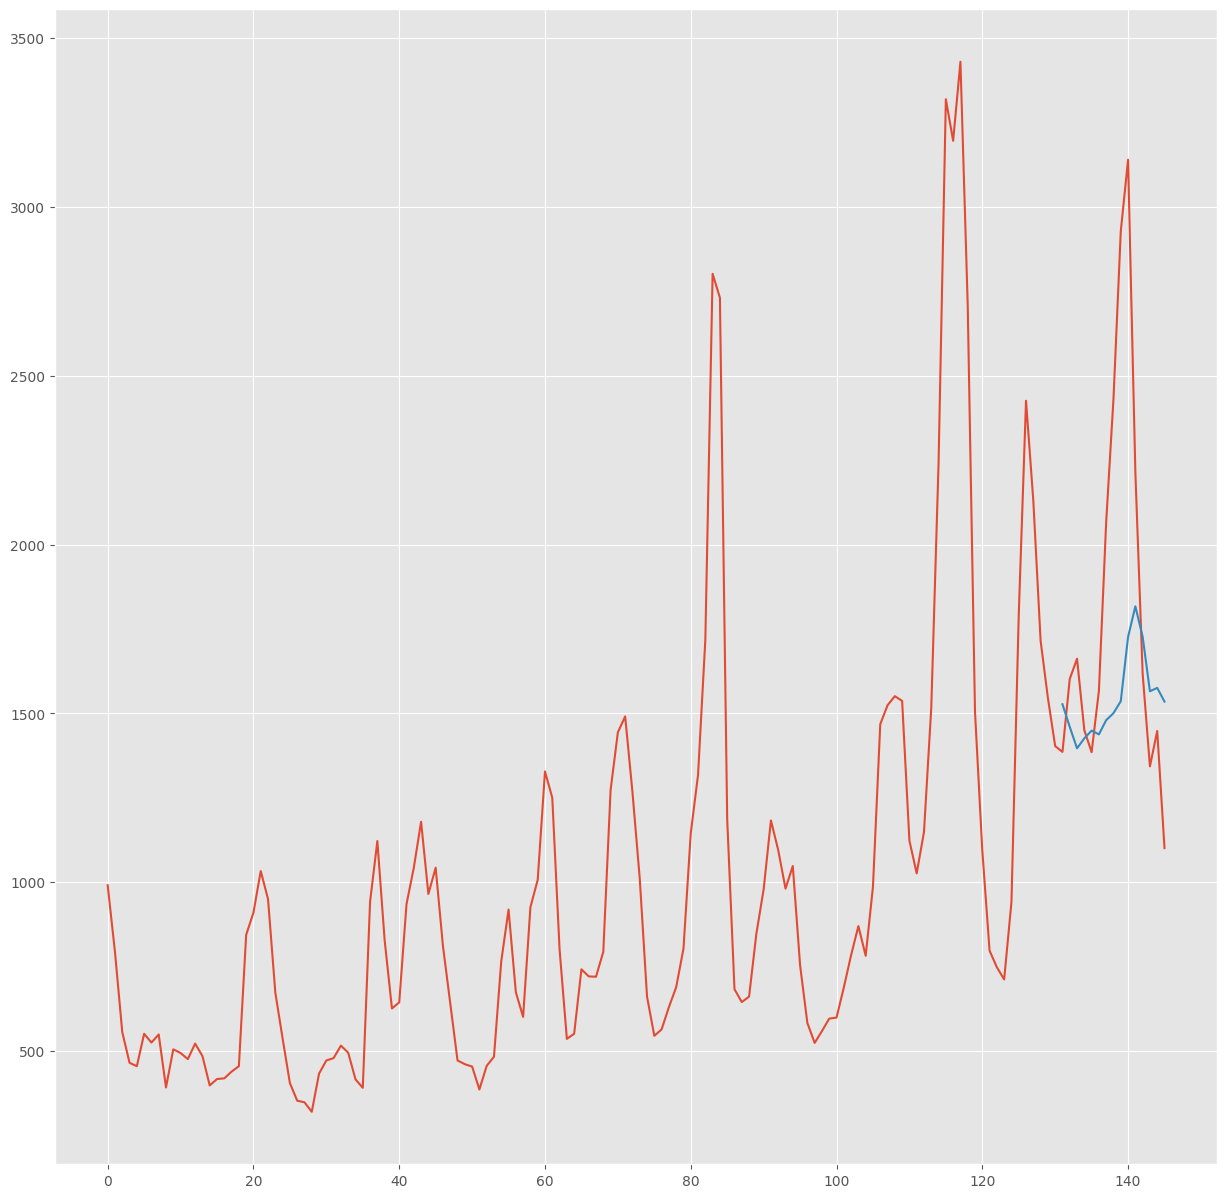

In [74]:
plt.plot(dfBang.months_since_min, dfBang['priceMod'])
plt.plot(dfBang.months_since_min[-15:], prediction)

## Выделение тренда и сезонности

При работе с временными рядами выделяют два действия:
- Дифференцирование — расчет разницы с определенным временным лагом
- Декомпозиция — моделирование как тренда, так и сезонности и удаление их из модели.

Предположим, что у вас имеются ежемесячные данные о пассажиропотоке на международных авиалиниях. Объем пассажиропотока имеет во времени возрастающий линейный тренд, и в ряде имеется ежегодно повторяющаяся закономерность — сезонность (большинство перевозок приходится на летние месяцы, кроме того, имеется пик меньшей высоты в районе декабрьских каникул). Цель декомпозиции как раз и состоит в том, чтобы отделить эти компоненты, то есть разложить ряд на составляющую тренда, сезонную компоненту и оставшуюся нерегулярную составляющую.

То есть каждый уровень временного ряда формируется под воздействием большого числа факторов, которые условно можно подразделить на три группы:
- факторы, формирующие тенденцию ряда
- факторы, формирующие циклические колебания ряда
- случайные факторы  

Рассмотрим воздействие каждого фактора на временной ряд в отдельности. Большинство временных рядов экономических показателей имеют тенденцию, характеризующую совокупное долговременное воздействие множества факторов на динамику изучаемого показателя. Все эти факторы, взятые в отдельности, могут оказывать разнонаправленное воздействие на исследуемый показатель. Однако в совокупности они формируют его возрастающую или убывающую тенденцию.

В большинстве случаев фактический уровень временного ряда можно представить как сумму или произведение трендовой, циклической и случайной компонент. Модель, в которой временной ряд представлен как сумма перечисленных компонент, называется **аддитивной** моделью временного ряда. Модель, в которой временной ряд представлен как произведение перечисленных компонент, называется **мультипликативной** моделью временного ряда.

**Аддитивная модель**
$${Y_t} = t (trend) + s (seasonality) + r (residual)$$

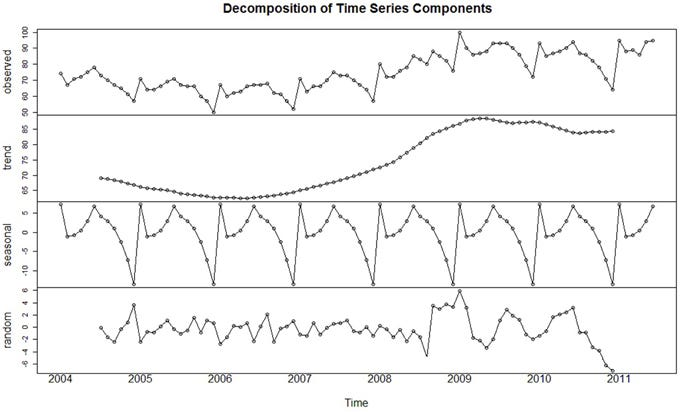

**Мультипликативная модель**
$${Y_t} = t (trend) * s (seasonality) * r (residual)$$

![](https://anomaly.io/wp-content/uploads/2015/12/multiplicative-model.png)

Как видим, отличие мультипликативной модели от аддитивной состоит в том, что в мультипликативной модели сезонная и случайная составляющие определены в виде относительных величин (коэффициентов), а в аддитивной модели – в виде абсолютных величин. Эти модели в практических расчетах дадут близкие результаты, если амплитуда колебаний уровней ряда слабо изменяется во времени

#### Вопрос

Какие примеры аддитивных и мультипликаативных рядов из жизни вы знаете?

### Декомпозиция
Декомпозируем наш временной ряд на тренд и сезонность

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [76]:
dfBang.index = dfBang.date
dfBang.head()

date  quantity  priceMod  priceModLog  priceMean  \
date                                                           
2004-01  2004-01    227832       991         6.90     884.57   
2004-02  2004-02    225133       793         6.68     884.57   
2004-03  2004-03    221952       556         6.32     884.57   
2004-04  2004-04    185150       465         6.14     884.57   
2004-05  2004-05    137390       455         6.12     884.57   

         months_since_min  priceLinear  priceLinearQuantity  
date                                                         
2004-01                 0       451.29               431.41  
2004-02                 1       455.50               434.28  
2004-03                 2       459.75               437.01  
2004-04                 3       464.03               428.67  
2004-05                 4       468.36               413.03

In [77]:
dfBang.index = dfBang.index.to_timestamp()

In [78]:
decomposition = seasonal_decompose(dfBang.priceModLog, model = "additive")

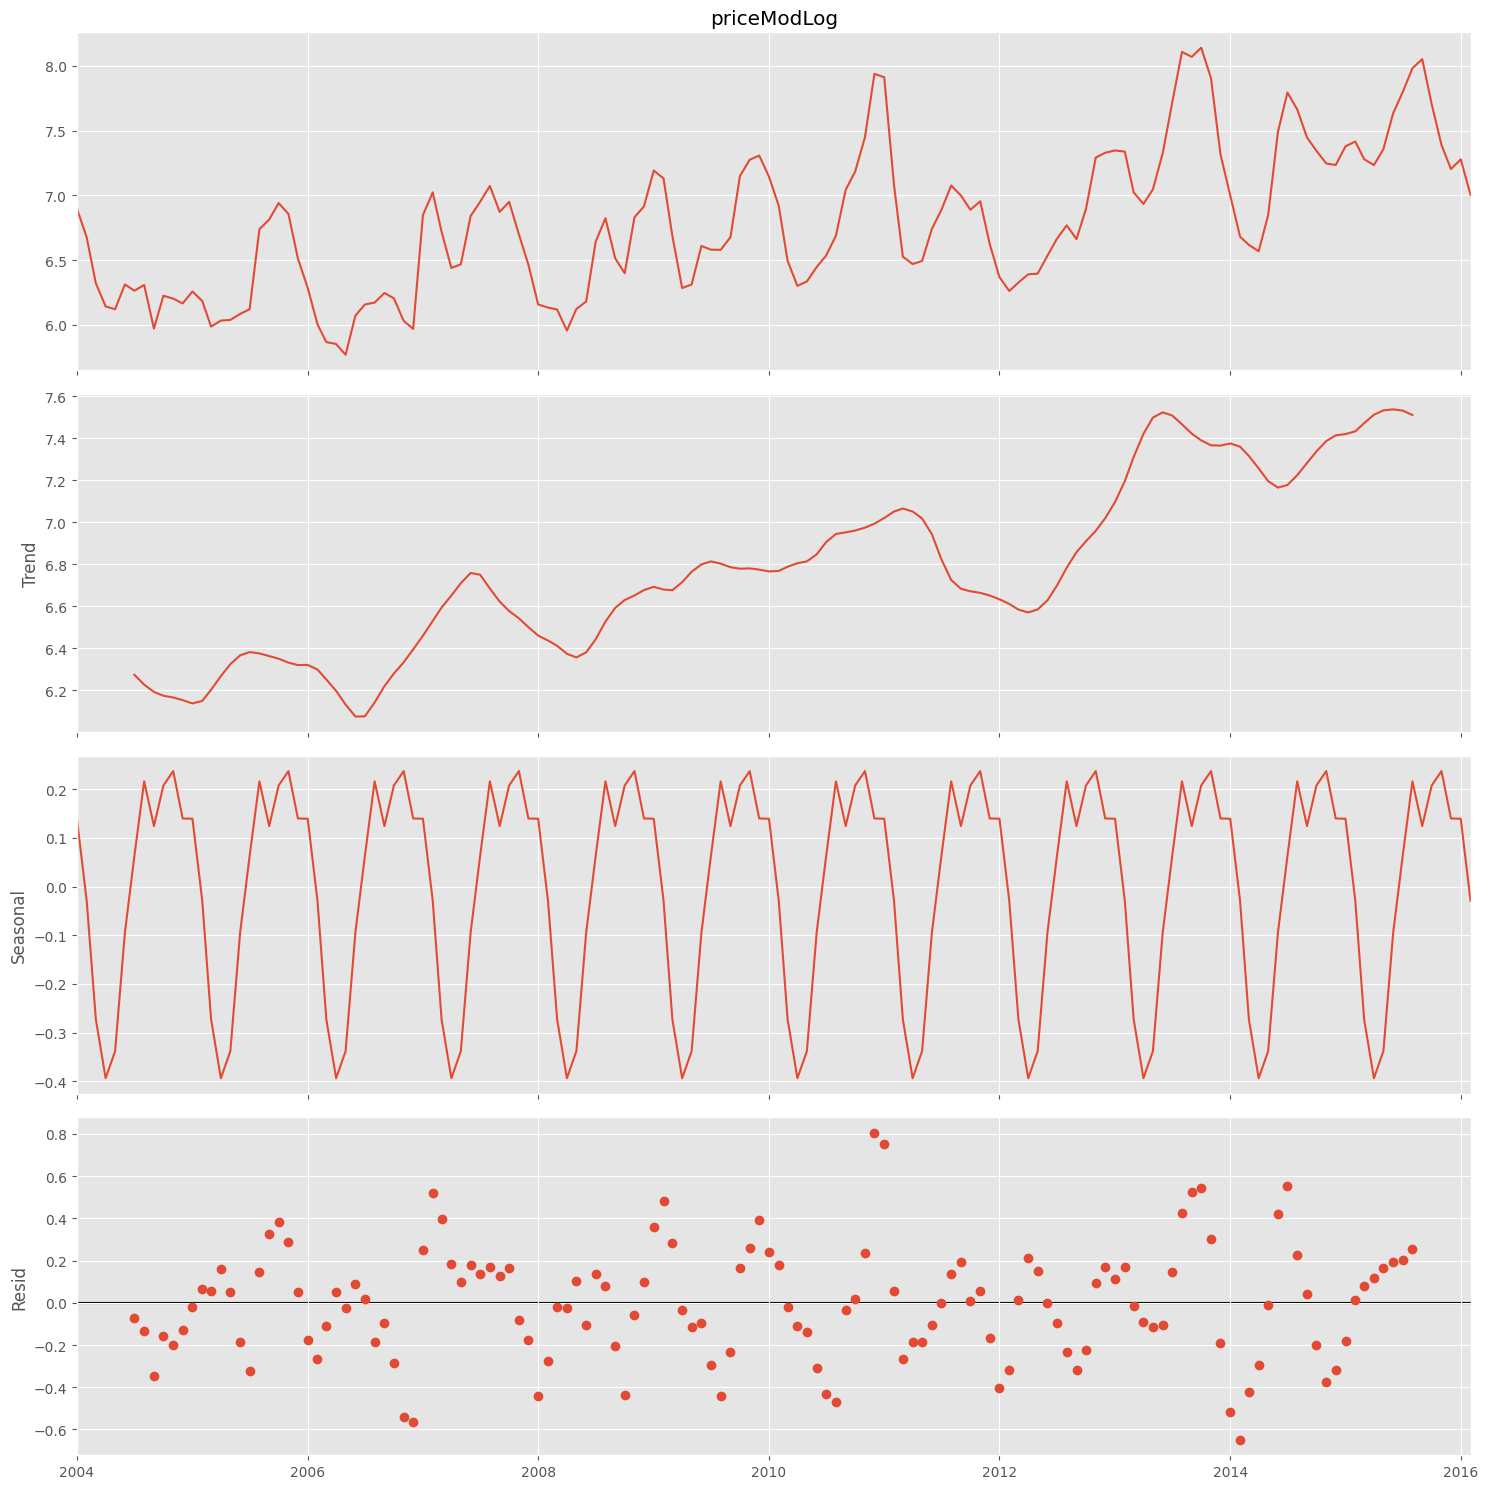

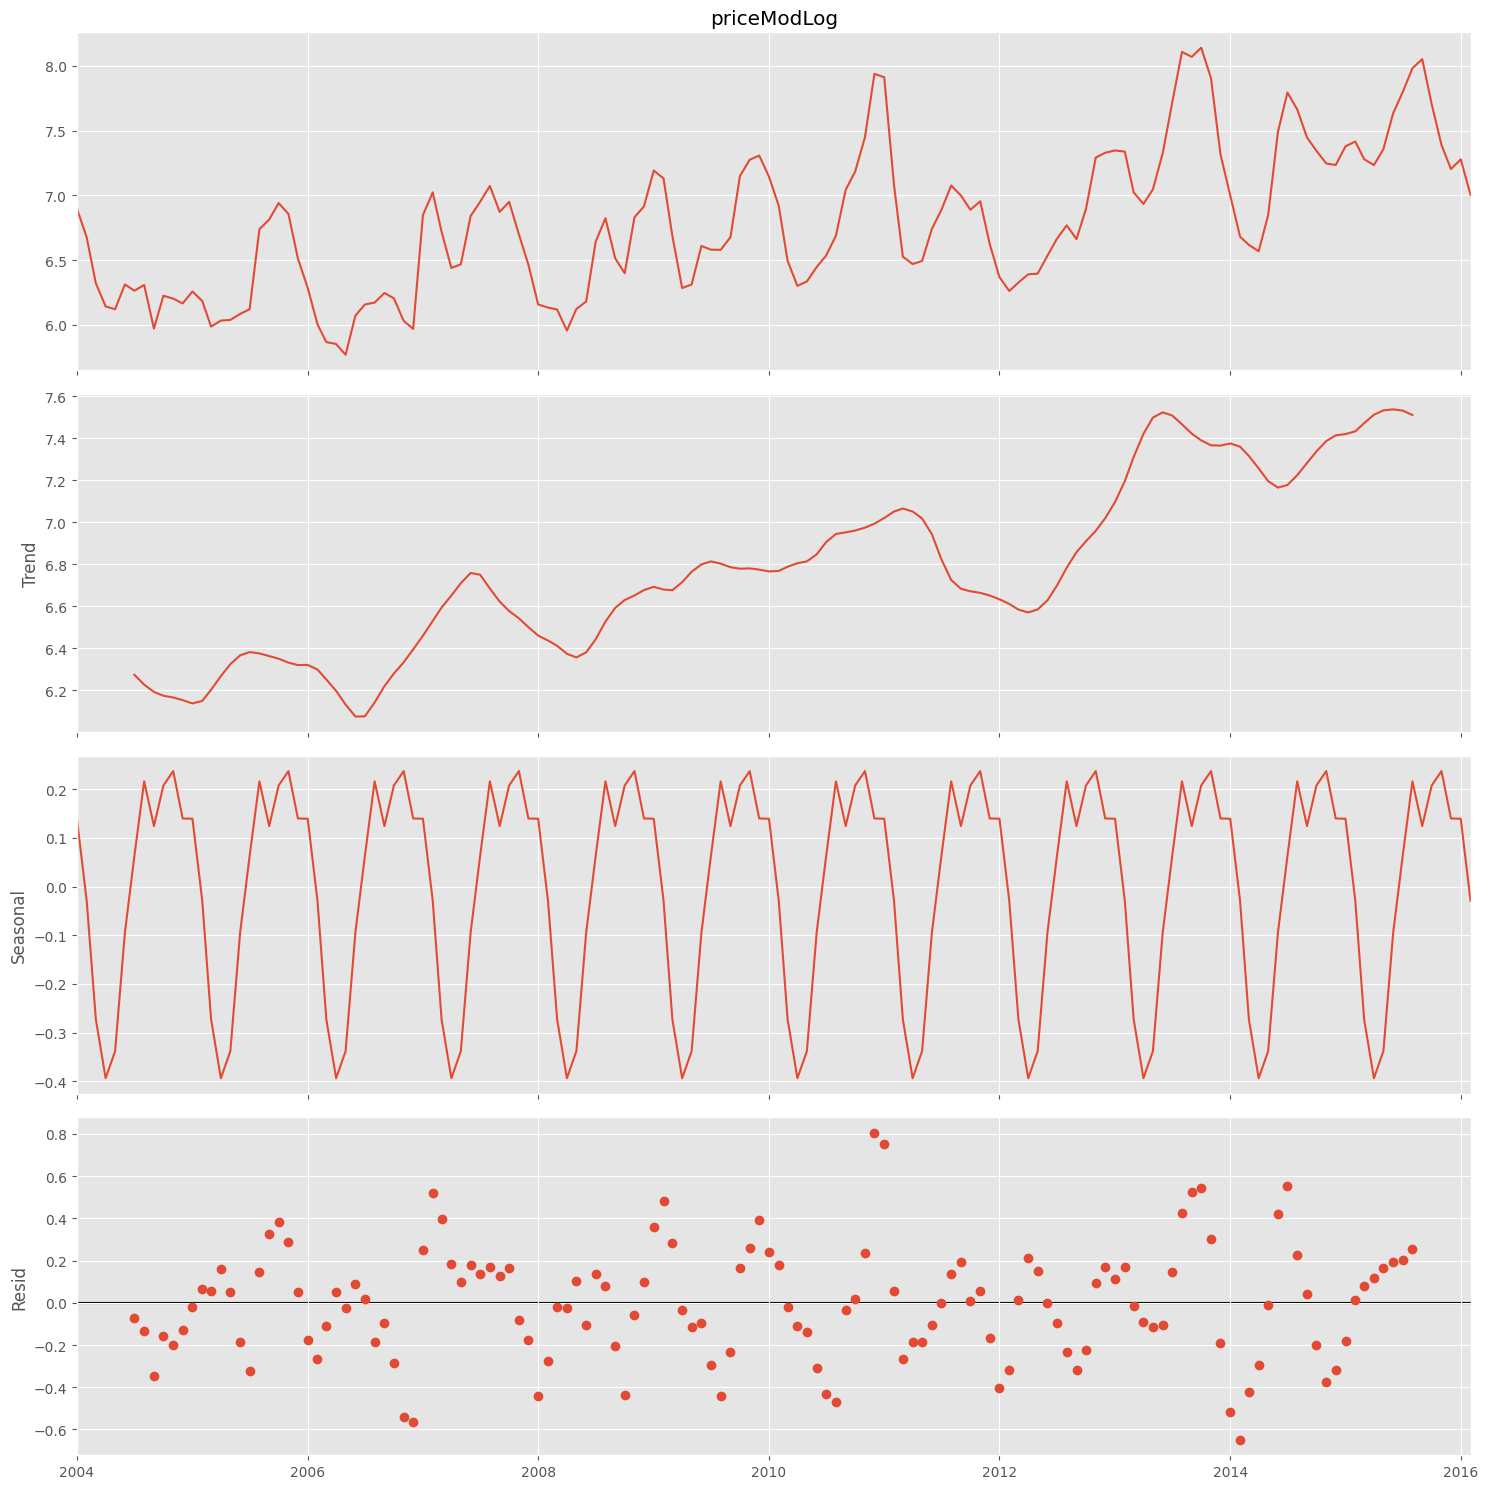

In [79]:
decomposition.plot()

In [80]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [81]:
# Построим ряд по тренду и сезонности
dfBang["priceDecomp"] = np.exp(trend + seasonal)

In [82]:
# Расчет RMSE
model_Decomp_RMSE = RMSE(dfBang.priceDecomp, dfBang.priceMod)
model_Decomp_RMSE

np.float64(374.1085846480237)

<Axes: xlabel='months_since_min'>

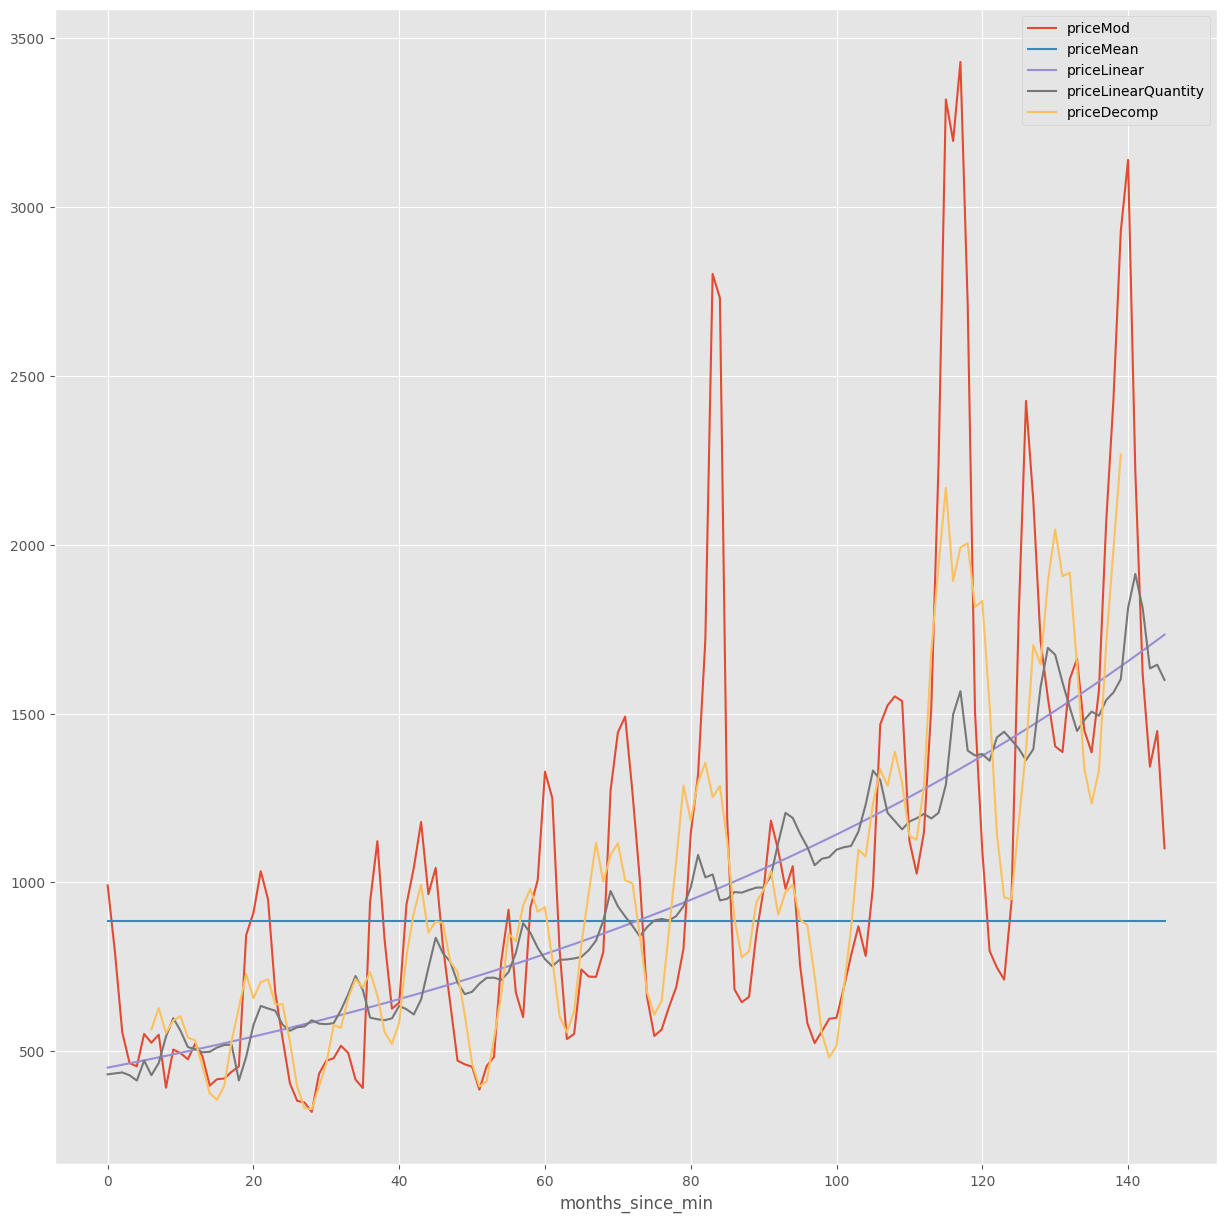

In [83]:
dfBang.plot(kind="line", x="months_since_min", y = ["priceMod", "priceMean", "priceLinear", "priceLinearQuantity", "priceDecomp"])

In [84]:
dfBangResults

Model   RMSE
0    Mean 683.95
1  Linear 518.52

In [85]:
dfBangResults.loc[3,"Model"] = "priceDecomp"
dfBangResults.loc[3,"RMSE"] = model_Decomp_RMSE
dfBangResults.head()

Model   RMSE
0         Mean 683.95
1       Linear 518.52
3  priceDecomp 374.11

## Задание для самостоятельного решения (декомпозиция ряда)



### Задание 9. Декомпозиция ряда

*Декомпозируйте ряд остатков для величины `quantity`*

In [86]:
### your code here

## Стационарность ряда

Перед тем, как перейти к другим моделям, стоит сказать о таком важном свойстве временного ряда, как стационарность. Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках:

![](https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png)  
Временной ряд справа не является стационарным, так как его матожидание со временем растёт

![](https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png)  
Здесь не повезло с дисперсией — разброс значений ряда существенно варьируется в зависимости от периода

![](https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png)  
На последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций


Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

In [87]:
test = sm.tsa.adfuller(dfBang.priceMod)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -4.004401077671534
p-value:  0.00138764044231547
Critical values:  {'1%': np.float64(-3.4769274060112707), '5%': np.float64(-2.8819726324025625), '10%': np.float64(-2.577665408088415)}
Единичных корней нет, ряд стационарен


### Расчет лагов
Представим временной ряд в виде последовательности разницы между значениями.  
Рассчитаем лаги, выведем их на графике

In [88]:
# Рассчитаем лаги
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()

<Axes: xlabel='priceModLogShift1', ylabel='priceModLog'>

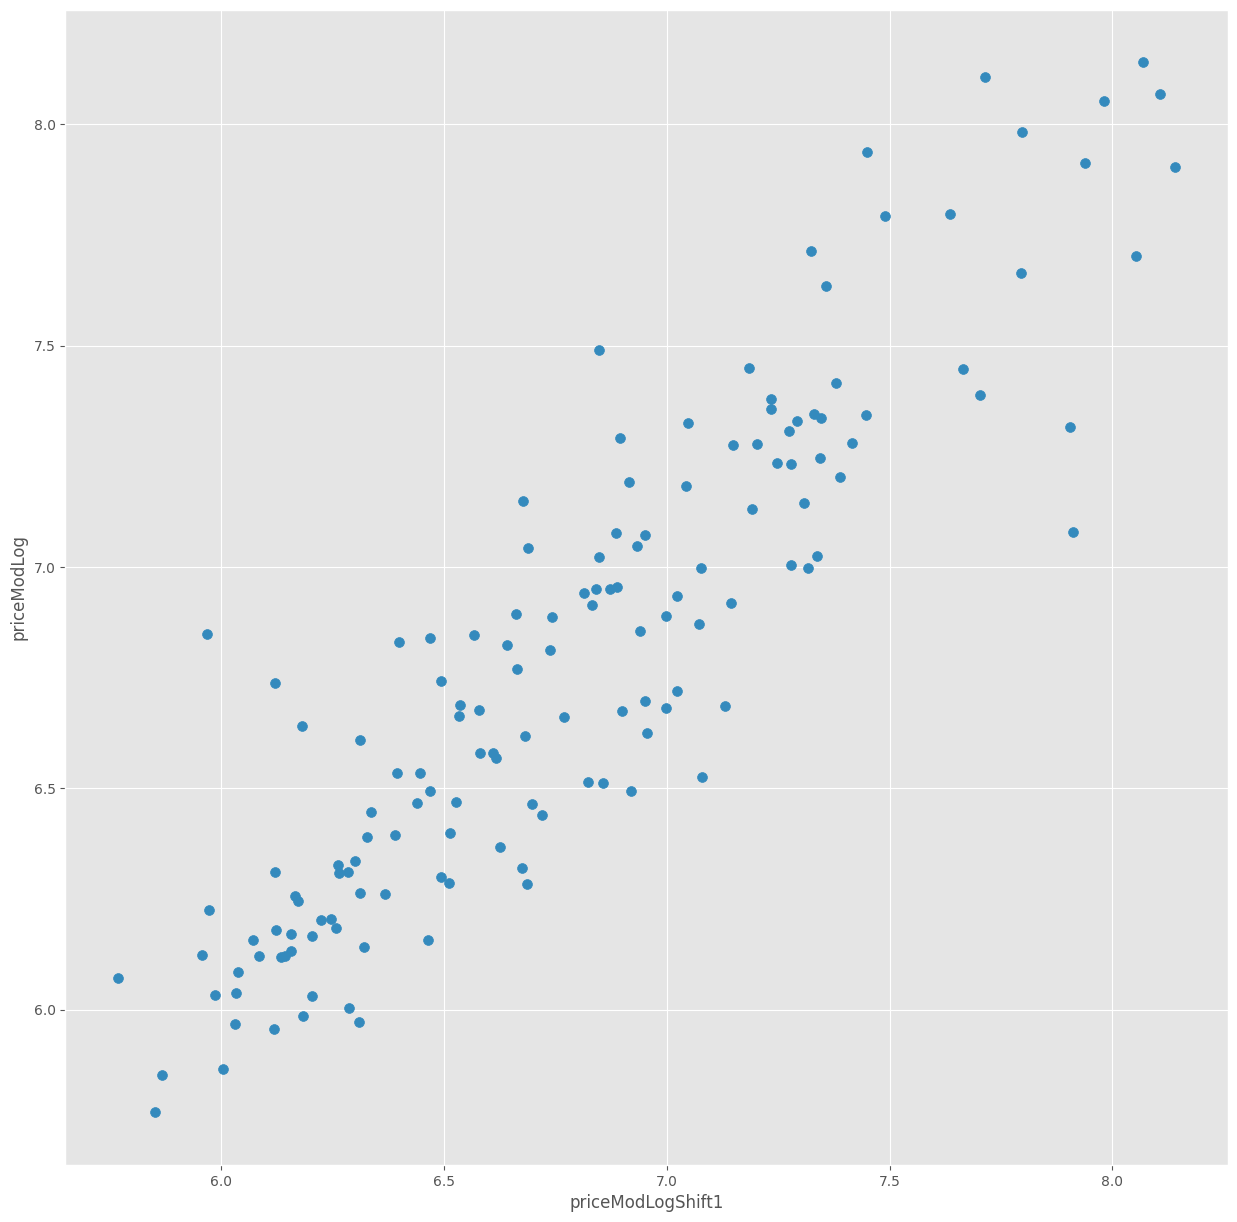

In [89]:
# Выведем на графике priceModLog и priceModLogShift1
dfBang.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50)

In [90]:
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1

<Axes: xlabel='date'>

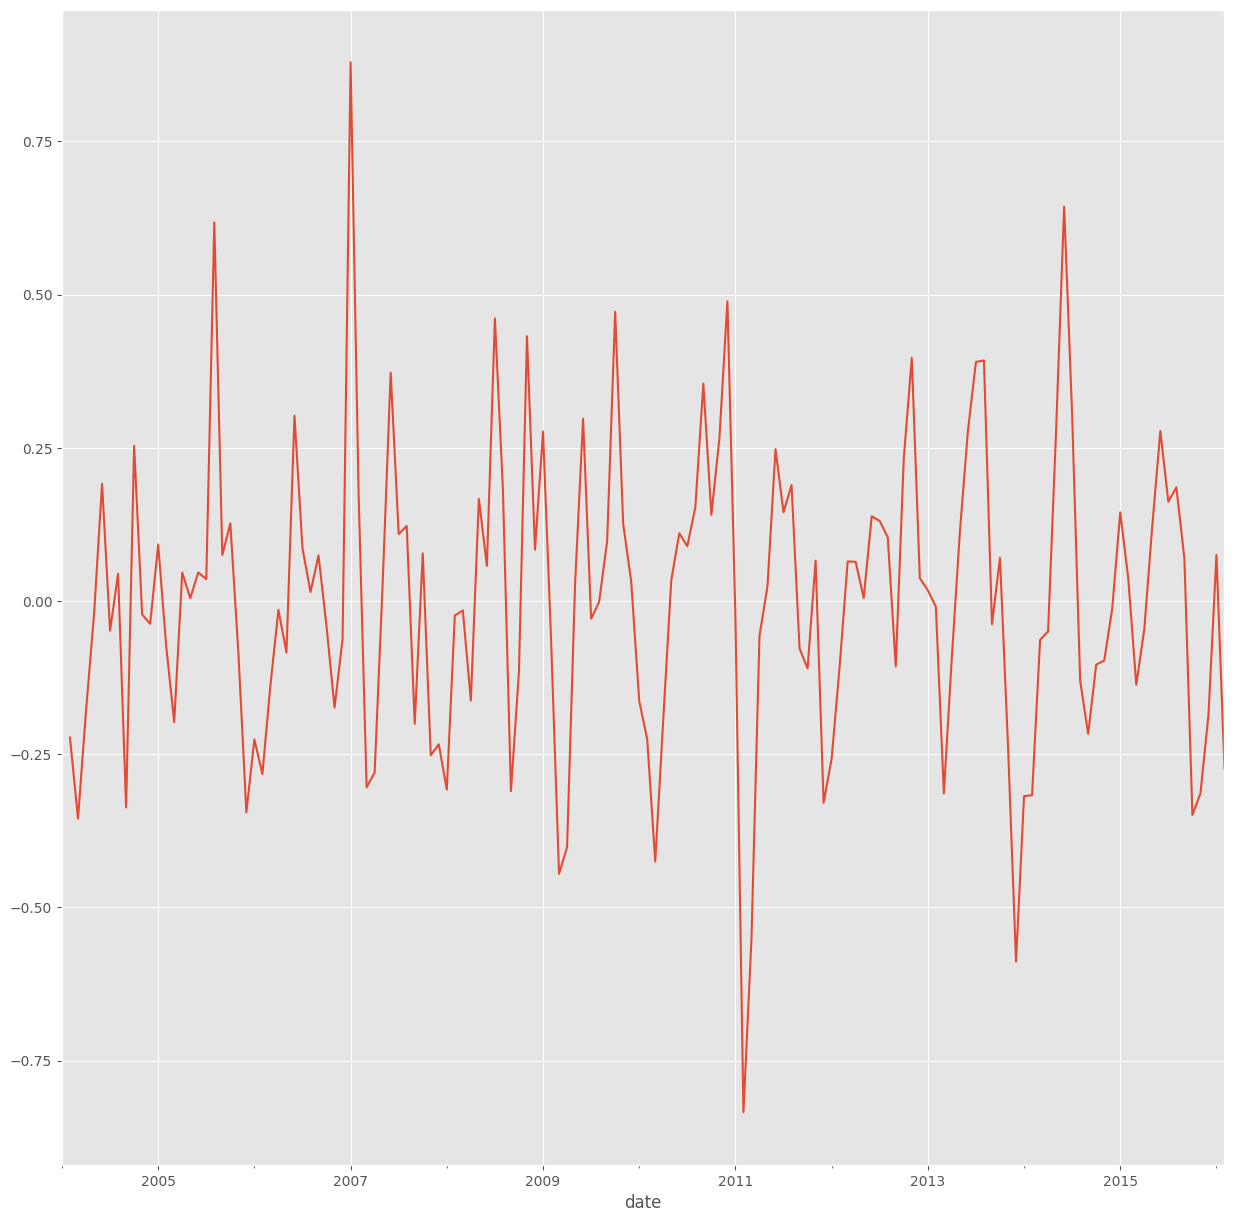

In [91]:
dfBang.priceModLogDiff.plot()

## Класс моделей АRIMA

Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.  
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:  
- p — порядок компоненты AR
- d — порядок интегрированного ряда (порядок разности временного ряда)
- q — порядок компонетны MA  


Параметр d равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную (ACF) и частично автокорреляционную (PACF) функции для ряда первых разностей.
ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.  

Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: acf и pacf.  
Можем построить графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов.

In [92]:
ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace = True)

In [93]:
ts = dfBang.priceModLog
ts_diff = dfBang.priceModLogDiff
ts_diff.dropna(inplace = True)

In [94]:
# ACF и PACF
from statsmodels.tsa.stattools import acf, pacf

In [95]:
lag_acf = acf(ts_diff, nlags=20)

In [96]:
lag_acf

array([ 1.        ,  0.40215445, -0.02855346, -0.21472715, -0.23756032,
       -0.26332645, -0.22038359, -0.08576989, -0.0754398 ,  0.01497797,
        0.12361818,  0.20862956,  0.158123  ,  0.02053933, -0.01290934,
       -0.07097602, -0.17993659, -0.09514604, -0.04878255, -0.08854117,
       -0.18810881])

In [97]:
ACF = pd.Series(lag_acf)

In [98]:
ACF

0     1.00
1     0.40
2    -0.03
3    -0.21
4    -0.24
5    -0.26
6    -0.22
7    -0.09
8    -0.08
9     0.01
10    0.12
11    0.21
12    0.16
13    0.02
14   -0.01
15   -0.07
16   -0.18
17   -0.10
18   -0.05
19   -0.09
20   -0.19
dtype: float64

<Axes: >

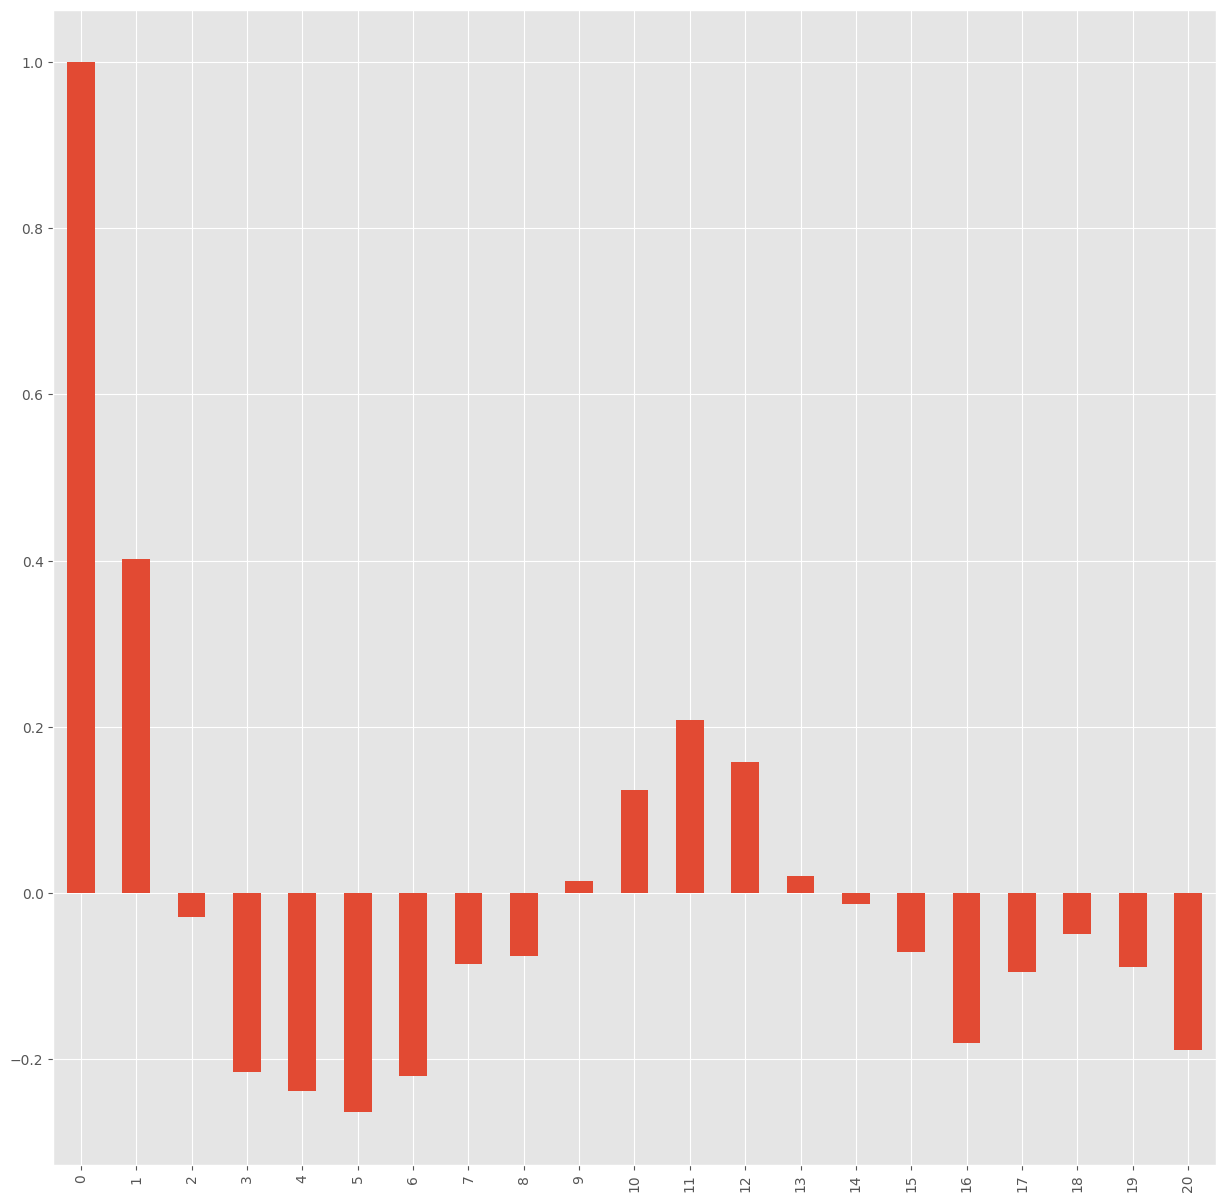

In [99]:
ACF.plot(kind = "bar")

In [100]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [101]:
PACF = pd.Series(lag_pacf)

<Axes: >

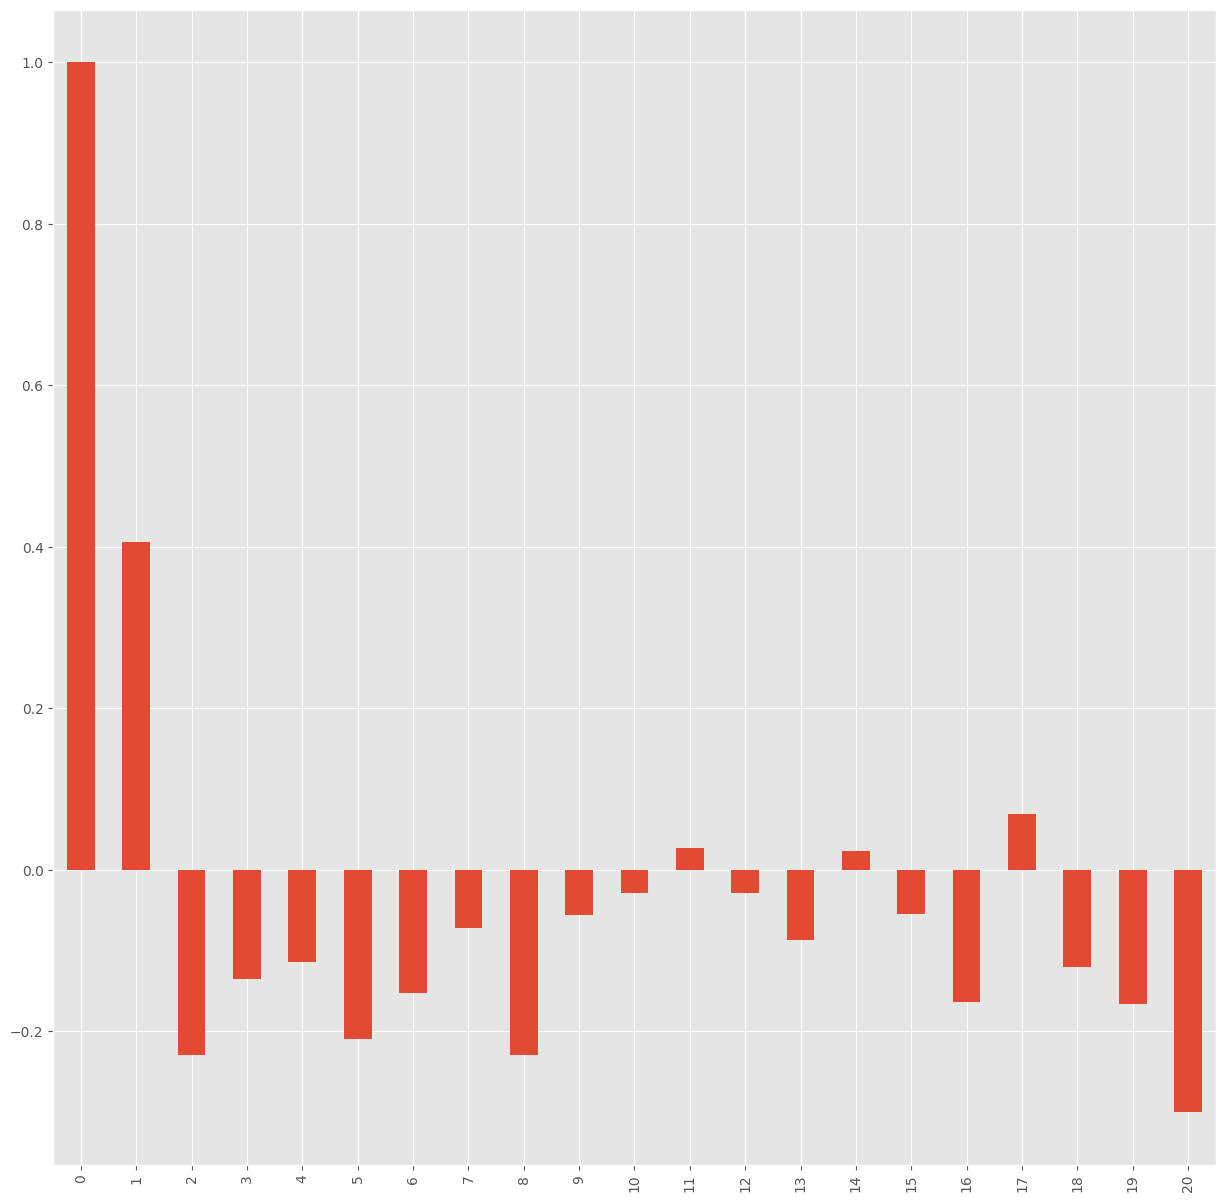

In [102]:
PACF.plot(kind = "bar")

### Построение модели

In [103]:
from statsmodels.tsa.arima.model import ARIMA

In [104]:
ts_diff.head()

date
2004-02-01   -0.22
2004-03-01   -0.36
2004-04-01   -0.18
2004-05-01   -0.02
2004-06-01    0.19
Freq: MS, Name: priceModLogDiff, dtype: float64

In [105]:
# ARIMA Model (1,0,1)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))

In [106]:
results_ARIMA = model_AR1MA.fit()

In [107]:
results_ARIMA.fittedvalues.head()

date
2004-02-01   -0.00
2004-03-01   -0.09
2004-04-01   -0.14
2004-05-01   -0.04
2004-06-01    0.00
Freq: MS, dtype: float64

<Axes: xlabel='date'>

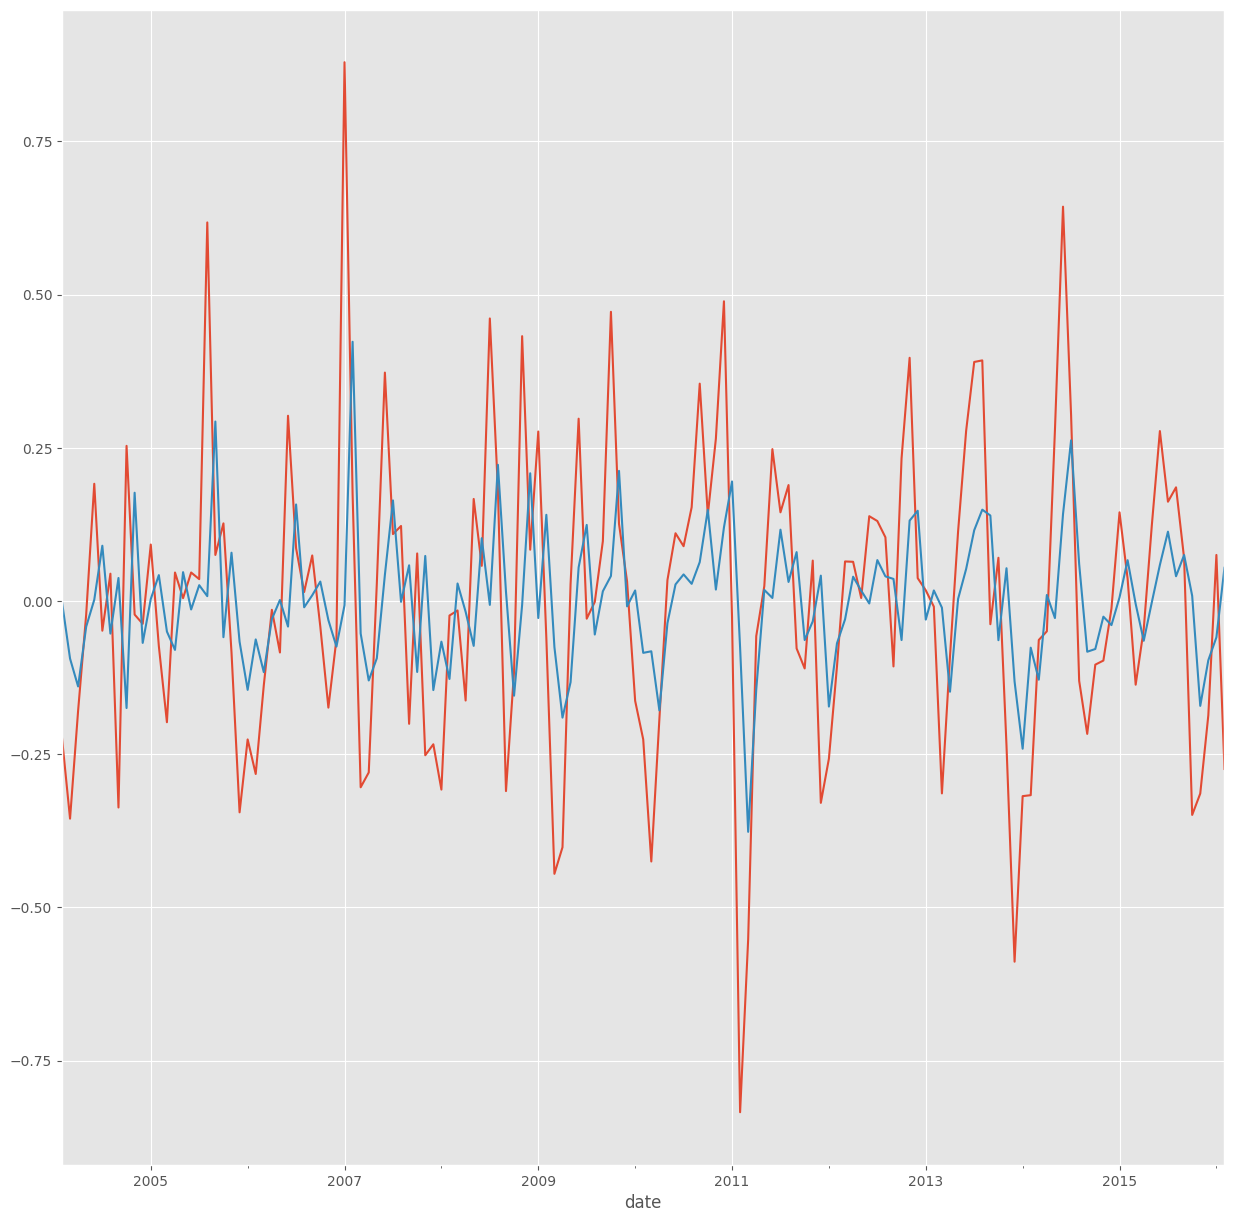

In [108]:
ts_diff.plot()
results_ARIMA.fittedvalues.plot()

In [109]:
ts_diff.sum()

np.float64(0.1052596023926915)

In [110]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

date
2015-10-01    0.01
2015-11-01   -0.17
2015-12-01   -0.10
2016-01-01   -0.06
2016-02-01    0.05
Freq: MS, dtype: float64

In [111]:
predictions_ARIMA_diff.sum()

np.float64(0.07147674324065963)

In [112]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

date
2015-10-01   0.34
2015-11-01   0.17
2015-12-01   0.08
2016-01-01   0.02
2016-02-01   0.07
Freq: MS, dtype: float64

In [113]:
ts.iloc[0]

np.float64(6.898714534329988)

In [114]:
predictions_ARIMA_log = pd.Series(ts.iloc[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.tail()

date
2015-10-01   7.24
2015-11-01   7.07
2015-12-01   6.98
2016-01-01   6.92
2016-02-01   6.97
Freq: MS, dtype: float64

In [115]:
dfBang['priceARIMA'] = np.exp(predictions_ARIMA_log)

<Axes: xlabel='months_since_min'>

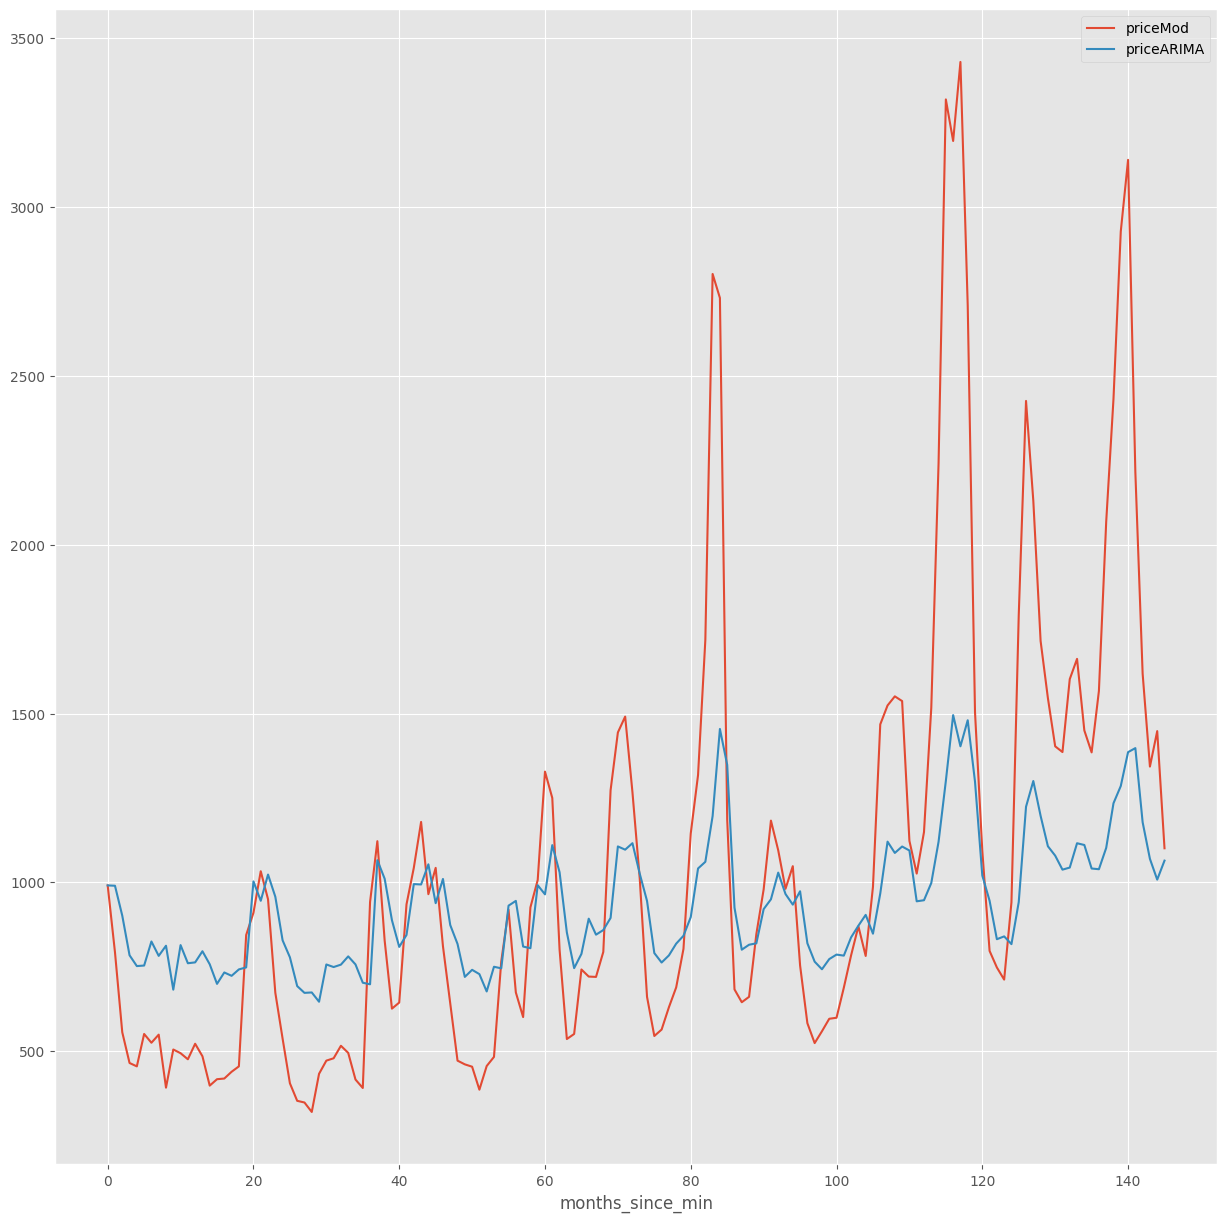

In [116]:
dfBang.plot(kind="line", x="months_since_min", y = ["priceMod", "priceARIMA"])

<Axes: xlabel='months_since_min'>

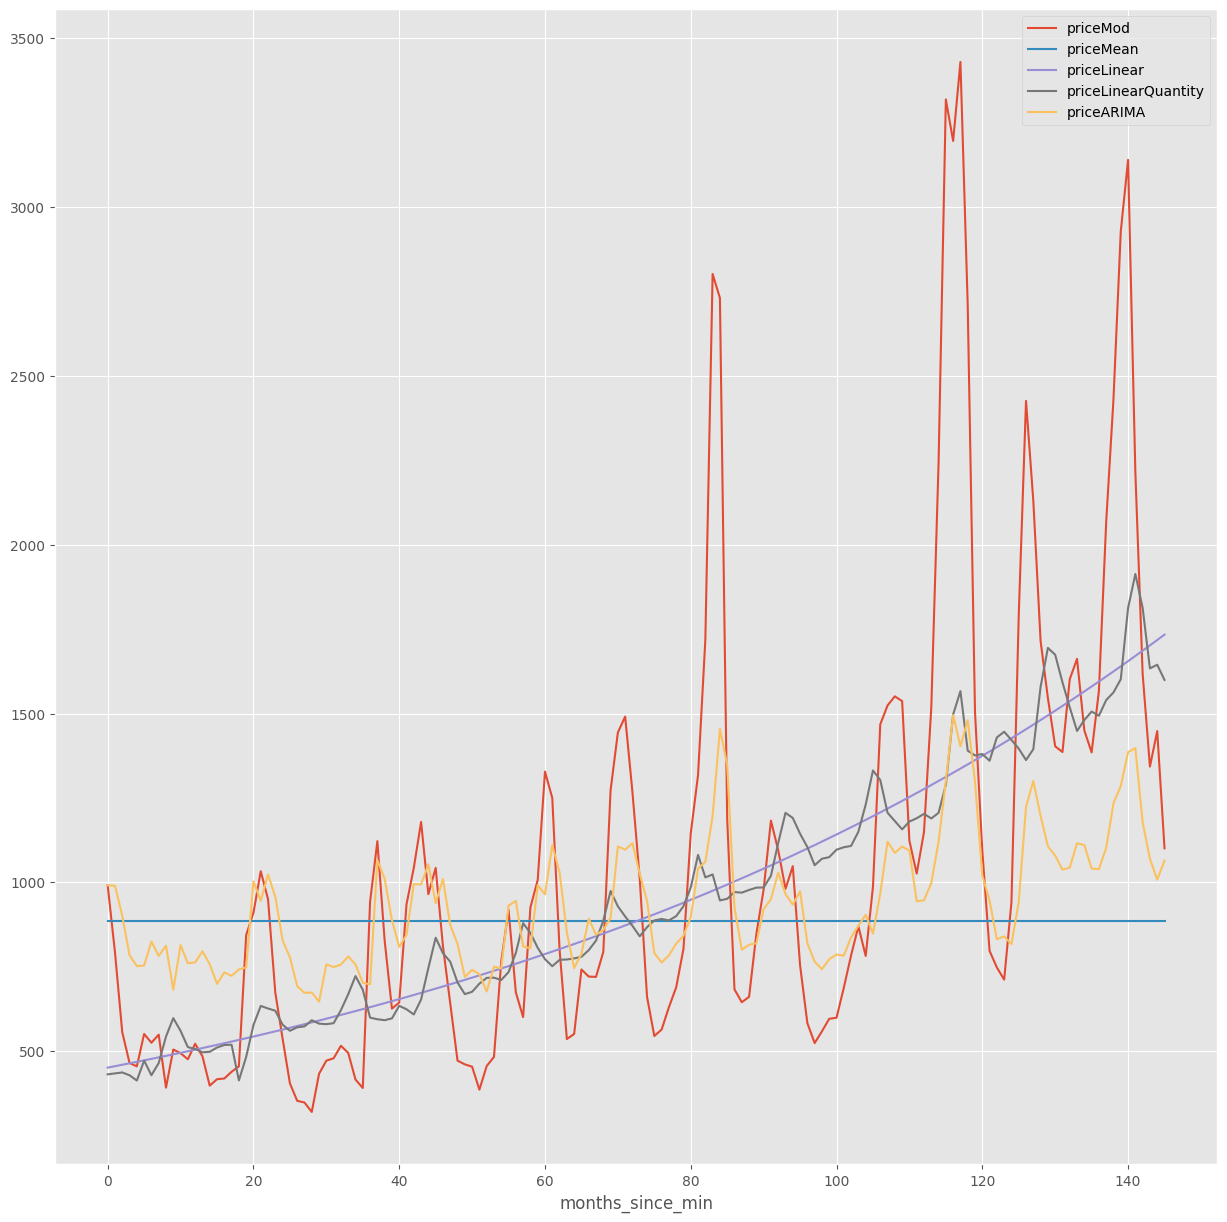

In [117]:
dfBang.plot(kind="line", x="months_since_min", y = ["priceMod", "priceMean", "priceLinear",
                                             "priceLinearQuantity", "priceARIMA"])

In [118]:
# RMSE
model_arima_RMSE = RMSE(dfBang.priceARIMA, dfBang.priceMod)
model_arima_RMSE

np.float64(517.748047364647)

Обычно подбор параметров для ARIMA — сложный и трудоемкий процесс.  


23-го февраля 2017 года команда Core Data Science из Facebook выпустила новую библиотеку для работы с временными рядами — Prophet. Попробуйте применить новую библиотеку и посмотрите на удобство в использовании и качество предсказания.

## Финальные размышления

На семинаре мы ознакомились с разными подходами к анализу и прогнозированию временных рядов.

Была рассмотрена интегрированная модель авторегрессии – скользящего среднего (ARIMA), как базовая модель прогнозирования.  

Как вы уже убедились, серебряной пули для решения такого рода задач пока нет.  Методы, разработанные в 60-е годы прошлого века, (а некоторые и в начале 19-го), по-прежнему пользуются популярностью наравне с неразобранными в рамках данной статьи LSTM или RNN.

Отчасти это связано с тем, что задача прогнозирования, как и любая другая задача, возникающая в процессе работы с данными — во многом творческая и уж точно исследовательская. Несмотря на обилие формальных метрик качества и способов оценки параметров, для каждого временного ряда часто приходится подбирать и пробовать что-то своё. Не последнюю роль играет и баланс между качеством и трудозатратами.